# Generate single-cell UMAPs based on DamID data

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from glob import glob
from scipy.signal import gaussian, fftconvolve
from matplotlib import gridspec
from scipy import signal
from scipy import stats

rs = np.random.RandomState()
rs.seed(42)

import sys
sys.path.append('../../combining_all_data/bin/')
sys.path.append('../bin/')
from preimplantation_toolkit import *
import preimplantation_load_data as ld

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

FIGOUTDIR = '../output/figures/1_Preimplantation.structural_properties_of_LADs.part2d.single-cell_UMAPs/'

In [3]:
! mkdir -p $FIGOUTDIR || true;

In [4]:
HOME = '/Users/f.rang/surfdrive/Kind/data/'

BINSIZE = 100000
MINMAP_PER_KB = 1
MINMAP = int(MINMAP_PER_KB * BINSIZE / 1000)

ANNOFN = HOME + 'projects/preimplantation/combining_all_data/metadata/FR230814.samplesheet.tsv'
COLORFN = '../colors/manuscript_colors.tsv'

# DamID file names
COUNTS = '../../combining_all_data/data/damid_counts/FR230814.DamID.sample_counts.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
BINARY = '../../combining_all_data/data/damid_binary/FR230814.DamID.sample_smooth_binary.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
CONTFC = '../../combining_all_data/data/damid_CF/FR230814.DamID.contact_frequency.{construct}.{stage}.{treatment}.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
INSILICO = '../../combining_all_data/data/damid_insilico/FR230814.DamID.insilico_counts.{construct}.{stage}.{treatment}.{genotype}.{sample}_samples.damid_pass.binsize_{binsize:d}.hdf5'

ALLELEFILTFN = '../../combining_all_data/data/damid_allelic_filter/FR230814.allelic_filter_based_on_visibility_and_bias.{genotype}.binsize_{binsize:d}.hdf5'

# DamID mappability
MAPFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.bowtie2_very_sensitive_N1.readlength_65.counts.pos.hdf5"
POSFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.posarray.hdf5"

# Gene information
GENESFN = HOME + 'references/mouse/mm10/genomic_element_info/FR200630.BioMart.mm10.all_genes.top_transcripts.txt.gz'
PARKFN = HOME + 'projects/preimplantation/DRA001066/data/tables/FR200923.Park_clusters_by_Ensembl_ID.tsv'

# Repeat information


# 1. Loading our own data

In [5]:
color_dict = ld.load_color_dict(COLORFN)

## 1.1 Loading samplesheet

In [6]:
stage_order = ['zygote', '2cell', '8cell', 'mESC']
chrom_order = [str(c) for c in range(1,20)] + ['X', 'Y']
treatment_order = ['no_treatment', 'EED_mKO', 'EED_ctrl', 'Cbx7(CD)-Lap2b', 'Lap2b']

In [7]:
anno = pd.read_csv(ANNOFN, sep='\t')
anno = anno[anno['construct'] == 'Lmnb1'].reset_index(drop=True)
anno = anno[anno['stage'].isin(stage_order)]
anno = anno[anno.treatment.isin(treatment_order)]
anno = anno[anno.cellcount == 1]
anno = anno.set_index('damid_name')
anno = anno[anno.DamID_PASS]

In [8]:
anno.groupby(['stage', 'genotype', 'treatment']).size()

stage   genotype                treatment     
2cell   C57BL/6J_x_JF1/Ms       EED_ctrl           87
                                EED_mKO            54
        CBAB6F1_x_CAST/EiJ      Cbx7(CD)-Lap2b     39
                                Lap2b              11
                                no_treatment       26
        homozygous              Cbx7(CD)-Lap2b     28
                                Lap2b              31
                                no_treatment      197
8cell   CBAB6F1_x_CAST/EiJ      Cbx7(CD)-Lap2b     35
                                no_treatment       21
        homozygous              no_treatment      183
mESC    129S1/SvImJ_x_CAST/EiJ  no_treatment      268
zygote  CBAB6F1_x_CAST/EiJ      no_treatment       14
        homozygous              no_treatment      107
dtype: int64

## 1.2 Loading mappability

In [9]:
GENOTYPE2PARENT = {
    '129S1/SvImJ_x_CAST/EiJ': {
        'maternal': 'unique_129S1_SvImJ_snps',
        'paternal': 'unique_CAST_EiJ_snps'
    },
    
    'CBAB6F1_x_CAST/EiJ': {
        'maternal': 'unique_CBABL6F1_snps',
        'paternal': 'unique_CAST_snps'
    },
    
    'C57BL/6J_x_JF1/Ms': {
        'maternal': 'unique_C57BL_6J_snps',
        'paternal': 'unique_JF1_Ms_snps'
    }
}

In [10]:
mapab = ld.load_mappability(POSFN, MAPFN, chrom_order, BINSIZE)

In [11]:
mapab_gt = ld.load_mapab_from_count_file_heterozygous(COUNTS, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

## 1.3 Loading data

__Sample counts__

In [12]:
damid_counts = ld.load_sample_damid_counts_heterozygous(COUNTS, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ maternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ paternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ combined
Dam-Lmnb1 C57BL/6J_x_JF1/Ms maternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms paternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms combined
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ maternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ paternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ combined
Dam-Lmnb1 homozygous combined


__Binary sample counts__

In [13]:
damid_binary = ld.load_sample_damid_binary_heterozygous(BINARY, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ maternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ paternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ combined
Dam-Lmnb1 C57BL/6J_x_JF1/Ms maternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms paternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms combined
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ maternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ paternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ combined
Dam-Lmnb1 homozygous combined


__Allelic bin filtering__

In [14]:
allele_filt_gt = dict()

for gt in GENOTYPE2PARENT:
    
    fn = ALLELEFILTFN.format(genotype=gt.replace('/',''), binsize=BINSIZE)
    allele_filt_gt[gt] = dict()
    
    with h5py.File(fn, 'r') as f:
        for c in chrom_order:
            allele_filt_gt[gt][c] = f[c][:].astype(bool)
    
allele_filt_total = dict()

for c in chrom_order:
    filt = np.array([allele_filt_gt[gt][c] for gt in allele_filt_gt]).astype(int)
    filt = filt.sum(axis=0) == len(allele_filt_gt.keys())
    allele_filt_total[c] = filt

In [15]:
for c in allele_filt_total:
    print(c, allele_filt_total[c].mean())

1 0.8254861821903787
2 0.8034047226798462
3 0.83125
4 0.8081841432225064
5 0.8978919631093544
6 0.8462566844919787
7 0.7922971114167813
8 0.5710973724884081
9 0.8433734939759037
10 0.8606431852986217
11 0.8819672131147541
12 0.7693588676103247
13 0.8330564784053156
14 0.699759807846277
15 0.8769230769230769
16 0.8727087576374746
17 0.8240252897787145
18 0.9371554575523704
19 0.7964169381107492
X 0.4716208308952604
Y 0.0


## Single-cell heatmaps

In [16]:
def plot_data2(to_plot, chrom, mode=['rpkm', 'log2oe', 'binary'], parent='combined'):
    assert mode in ['rpkm', 'log2oe', 'binary'], 'invalid mode (rpkm, log2oe, binary)'

    PC = 1
    SMOOTH_STDDEV = 150000
    W = gaussian(np.ceil(SMOOTH_STDDEV / BINSIZE * 6 / 2) * 2 + 1, SMOOTH_STDDEV / BINSIZE)
    W /= W.sum()
    
    
    ind = to_plot.DamID_PASS if parent == 'combined' else to_plot.DamID_PASS_allelic
    g = to_plot[ind].groupby(['fusion_construct', 'stage', 'genotype', 'treatment'])
    
    nrow = len(g)
    ncol = 1
    hr = [len(df) for _, df in g]
    fig = plt.figure(figsize=(14, len(to_plot[ind])*0.08)) 
    gs = gridspec.GridSpec(nrow, ncol, height_ratios=hr, hspace=0.4)
    counter = 0
    mapab_rpkm = rpkm_normalize(mapab, binsize=BINSIZE)
    mapab_smooth = fftconvolve(mapab_rpkm[chrom], W, mode='same')

    for (construct, stage, genotype, treatment), df in g:
        ax0 = plt.subplot(gs[counter])
        counter += 1

        Y0 = []
        for sample, row in df.sort_values(by='unique_damid_counts').iterrows():
            
            if mode != 'binary':
                y = damid_counts[parent][sample]
                
                if parent == 'combined':
                    d = to_plot.loc[sample, 'unique_damid_counts']
                else:
                    d = to_plot.loc[sample, 'maternal_damid_counts'] + to_plot.loc[sample, 'paternal_damid_counts']
                    
                y = rpkm_normalize(y, binsize=BINSIZE, depth=d)[chrom]
                y = fftconvolve(y, W, mode='same')
                
                if mode == 'log2oe':
                    y = np.log2( (y + PC) / (mapab_smooth + PC) )
                
            else:
                y = damid_binary[parent][sample][chrom]
                
            Y0.append(y)
        Y0 = np.array(Y0)
        Y0[:,~allele_filt_gt[genotype][chrom]] = 0
        
        if mode == 'binary':
            ax0.pcolorfast(Y0, cmap='binary', vmin=0, vmax=1)
        elif mode == 'rpkm':
            ax0.pcolorfast(Y0, vmin=0, vmax=np.percentile(Y0, q=99.5), cmap='viridis')
        elif mode == 'log2oe':
            ax0.pcolorfast(np.atleast_2d(Y0), vmin=-1.2, vmax=1.2, cmap='bwr')
            
        ax0.set_title('{} - {} ({}) - {}'.format(construct, stage, genotype, treatment))

        xticks = np.arange(0, len(mapab[chrom]), int(10e6 / BINSIZE))
        xlabs = (xticks * BINSIZE / 1e6).astype(int)
        ax0.set_xticks(xticks)
        ax0.set_xticklabels(xlabs)
        ax0.tick_params(size=4)
        ax0.grid(False)
    ax0.set_xlabel('chromosome {} [Mb]'.format(chrom))
    plt.show()

In [17]:
anno[anno.DamID_PASS_allelic].groupby(['stage', 'genotype', 'treatment']).size()

stage   genotype                treatment     
2cell   C57BL/6J_x_JF1/Ms       EED_ctrl           51
                                EED_mKO            31
        CBAB6F1_x_CAST/EiJ      Cbx7(CD)-Lap2b     39
                                Lap2b              10
                                no_treatment       21
        homozygous              Cbx7(CD)-Lap2b     28
                                Lap2b              31
                                no_treatment      197
8cell   CBAB6F1_x_CAST/EiJ      Cbx7(CD)-Lap2b     22
                                no_treatment       17
        homozygous              no_treatment      183
mESC    129S1/SvImJ_x_CAST/EiJ  no_treatment      242
zygote  CBAB6F1_x_CAST/EiJ      no_treatment       13
        homozygous              no_treatment      107
dtype: int64

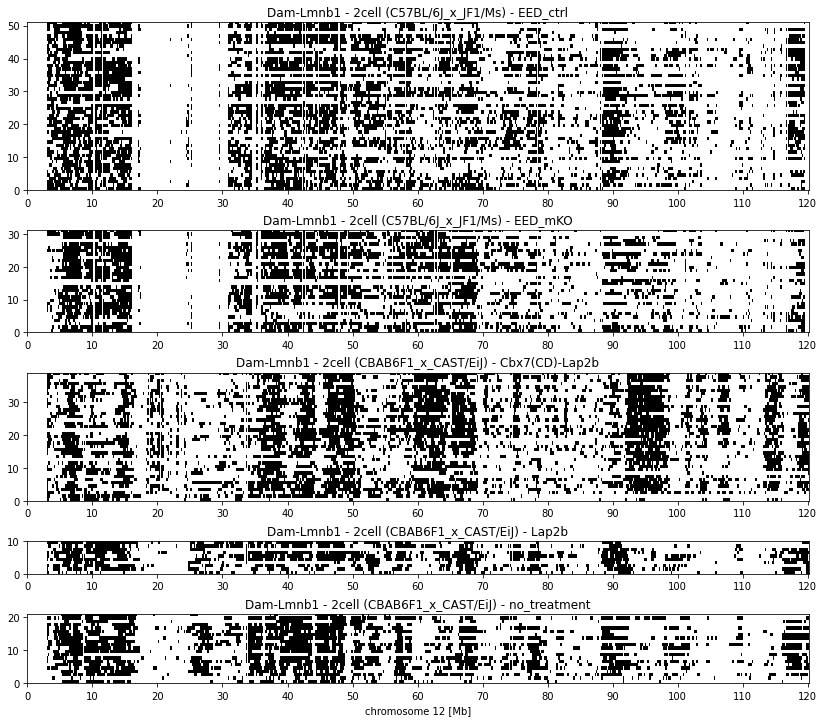

In [18]:
to_plot = anno[(anno.stage == '2cell') & anno.DamID_PASS & anno.is_heterozygous].copy()
plot_data2(to_plot, '12', mode='binary', parent='maternal')

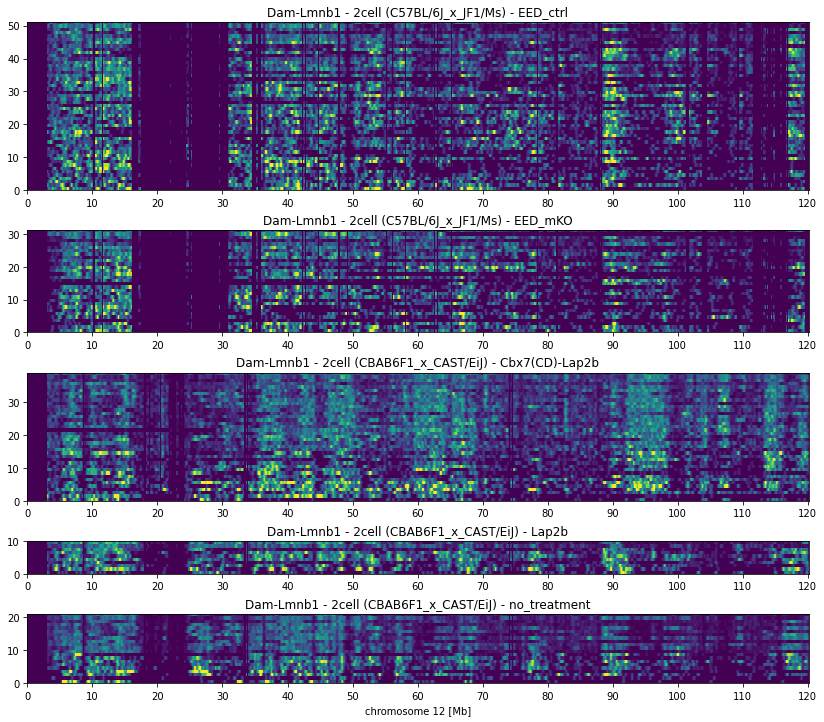

In [19]:
to_plot = anno[(anno.stage == '2cell') & anno.DamID_PASS & anno.is_heterozygous].copy()
plot_data2(to_plot, '12', mode='rpkm', parent='maternal')

## PCA & UMAP function

In [20]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

In [21]:
# generate marker dict for different stages:
marker_dict = {
    'zygote': 'o',
    '2cell': '^',
    '8cell': 'v',
    'mESC': 'd'
}

In [22]:
paul_tol_colors_12 = np.array([
    '#88CCEE', '#332288', 
    '#FEC44F', '#EC7014',
    '#44AA99', '#117733',
    '#CC6677', '#882255',
    '#DDCC77', '#999933',
    '#DDDDDD', '#555555'
])


paul_tol_colors_6 = np.array([
    '#4477AA', '#EE6677', '#66CCEE', '#CCBB44', '#228833', '#AA3377'
])

In [23]:
def compute_PCA_and_UMAP(samples, chroms, filt, npc=10, parent='combined', binary_data=True):
    np.random.seed(1)
    
    # select data
    data = list()
    not_found = list()
    for s in samples:
        if s not in damid_binary[parent]:
            print('%s not found for %s' % (s, parent))
            not_found.append(s)
            continue
            
        if binary_data:
            y = np.concatenate([damid_binary[parent][s][c] for c in chroms])[filt]
        else:
            y = np.concatenate([damid_counts[parent][s][c] for c in chroms])[filt]
            d = anno.loc[s,'unique_damid_counts'] if parent == 'combined' else anno.loc[s,['maternal_damid_counts', 'paternal_damid_counts']].sum()
            y = np.log1p(y / d * 1e4)
        data.append(y)
    data = np.array(data)
    samples = samples[~np.isin(samples, not_found)]
    
    # perform PCA
    n = min(50, min(data.shape))
    pca_all = PCA(n_components=n)
    pca_all.fit(data)
    data_transform = pca_all.transform(data)
    
    # format PCA results
    pca_results = pd.DataFrame(data_transform[:,:4], columns=['PC1', 'PC2', 'PC3', 'PC4'], index=samples)
    cols = ['runid', 'cellcount', 'stage', 'induction_system', 'genotype', 'treatment', 'number_embryos', 'technique', 'unique_damid_counts', 'IC_mappability']
    pca_results = pd.concat([pca_results, anno.loc[samples,cols].copy()], axis=1)
    
    explained_var = pca_all.explained_variance_ratio_
    singular_vals = pca_all.singular_values_
    
    # visualize explained variance
    fig, axes = plt.subplots(1,2,figsize=(10,3))
    ax = axes[0]
    X = np.arange(len(explained_var)) + 1
    Y = singular_vals
    ax.plot(X, Y, 'o-')
    ax.axvline(npc, c='k')
    ax.set_ylabel('singular values')
    ax.set_xlabel('# PCs')
    ax = axes[1]
    Y = explained_var.cumsum()*100
    ax.plot(X, Y, 'o-')
    ax.axvline(npc, c='k')
    ax.set_ylabel('explained variance [%]')
    ax.set_xlabel('# PCs')
    plt.show()
    plt.close()
    
    # compute correlation of selected PCs with depth
    has_corr = list()
    for pc in range(npc):
        A = data_transform[:,pc]
        if parent == 'combined':
            B = np.log10(anno.loc[samples, 'unique_damid_counts'].values)
        else:
            B = np.log10(anno.loc[samples, ['maternal_damid_counts', 'paternal_damid_counts']].sum(axis=1).values)
        r, p = stats.pearsonr(A, B)
        if abs(r) > 0.5:
            print('PC%d has correlation with depth of %.2f' % (pc+1, r))
            has_corr.append(True)
        else:
            has_corr.append(False)
    has_corr = np.array(has_corr)
    select_pc = np.arange(npc)
    
    # compute UMAP
    data_embedded = UMAP(random_state=1, min_dist=.5).fit_transform(data_transform[:,select_pc])
    
    # format UMAP results
    umap_results = pd.DataFrame(data_embedded, columns=['UMAP1', 'UMAP2'], index=samples)
    cols = ['runid', 'cellcount', 'stage', 'induction_system', 'genotype', 'treatment', 'number_embryos', 'technique', 'unique_damid_counts', 'IC_mappability', 'sex']
    umap_results = pd.concat([umap_results, anno.loc[samples,cols].copy()], axis=1)
    
    return pca_results, umap_results, explained_var

In [24]:
def plot_pca_results(pca_results, explained_var, parent='combined', additional_cols={}):

    pca_results['stage_treatment'] = pca_results.apply(axis=1, func = lambda r: '%s_%s' % (r['stage'], r['treatment']))
    tmp = {
        'Per stage': 'stage', 'Per genotype': 'genotype',
        'Per treatment': 'treatment', 'Per stage & treatment': 'stage_treatment',
        'Per run': 'runid',  'Per technique': 'technique'
    }
    
    if len(additional_cols) > 0:
        for k in additional_cols:
            tmp[k] = additional_cols[k]

    nplots = len(tmp) + 2
    ncol = 2
    nrow = int(np.ceil(nplots/ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow))
    plt.subplots_adjust(hspace=0.3, wspace=0.5)
    counter = 0

    for name, var in tmp.items():
        ax = axes.flatten()[counter]
        counter += 1
        
        nvals = len(pca_results[var].unique())
        assert nvals <= 20, 'Too many categories!'
        valcounter = 0
        
        for val, df in pca_results.groupby(var):
            
            # determine color
            if var in color_dict:
                if val in color_dict[var]:
                    clr = color_dict[var][val]
                else:
                    print('%s value \"%s\" not found in color dict' % (var, val))
                    clr = paul_tol_colors[valcounter]
                    valcounter += 1
            elif nvals <= 12:
                clr = paul_tol_colors_12[valcounter] if nvals > 6 else paul_tol_colors_6[valcounter]
                valcounter += 1
            else:
                clr = [sns.color_palette('tab20', n_colors=20)[valcounter]]
                valcounter += 1
            
            # plot datapoints of category
            ax.scatter(df['PC1'], df['PC2'], label=val, s=5, c=clr)


        ax.set_title(name, fontsize=14)
        ax.legend(loc=(1,0))

    tmp = {'depth [log10]': np.log10(pca_results['unique_damid_counts']), 'IC [log10]': np.log10(pca_results['IC_mappability'])}
    for name, clr in tmp.items():
        ax = axes.flatten()[counter]
        counter += 1

        p = ax.scatter(pca_results['PC1'], pca_results['PC2'], c=clr, cmap='Reds')
        plt.colorbar(p, ax=ax)
        ax.set_title(name, fontsize=14)

    for ax in axes.flatten():
        ax.grid(False)
        ax.set_xlabel('PC1 ({:.0f}%)'.format(explained_var[0]*100))
        ax.set_ylabel('PC2 ({:.0f}%)'.format(explained_var[1]*100))
        ax.set_box_aspect(1)

    while counter < (nrow*ncol):
        axes.flatten()[counter].remove()
        counter += 1
        
    plt.show()
    plt.close()
    
    fig, axes = plt.subplots(2,2,figsize=(8,8))
    plt.subplots_adjust(hspace=.4, wspace=.4)

    for icol, col in enumerate(['unique_damid_counts', 'IC_mappability']):
        X = np.log10(pca_results[col])
        if (col == 'unique_damid_counts') & (parent != 'combined'):
            X = np.log10(anno.loc[pca_results.index.values,['maternal_damid_counts', 'paternal_damid_counts']].sum(axis=1).values)
        for irow, pc in enumerate(['PC1', 'PC2']):
            Y = pca_results[pc]

            ax = axes[irow, icol]
            ax.scatter(X, Y, s=5)
            ax.set_xlabel('%s [log10]' % col)
            ax.set_ylabel(pc)
            
            r, p = stats.pearsonr(X, Y)
            ax.text(0.95, 0.95, 'r = %.2f' % r, ha='right', va='top', transform=ax.transAxes)
            
    plt.suptitle('Correlation of PC1-2 with depth and IC')
            
    plt.show()
    plt.close()
    

In [25]:
def plot_umap_results(umap_results, additional_cols = {}):
    umap_results['stage_treatment'] = umap_results.apply(axis=1, func = lambda r: '%s_%s' % (r['stage'], r['treatment']))
    tmp = {
        'Per stage': 'stage', 'Per genotype': 'genotype',
        'Per treatment': 'treatment', 'Per stage & treatment': 'stage_treatment',
        'Per run': 'runid', 'Per technique': 'technique'
    }
    
    if len(additional_cols) > 0:
        for k in additional_cols:
            tmp[k] = additional_cols[k]

    nplots = len(tmp) + 2
    ncol = 2
    nrow = int(np.ceil(nplots/ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=(7*ncol, 6*nrow))
    plt.subplots_adjust(hspace=0.4, wspace=0.5)
    counter = 0

    for name, var in tmp.items():
        ax = axes.flatten()[counter]
        counter += 1
           
        nvals = len(pca_results[var].unique())
        assert nvals <= 20, 'Too many categories!'
        valcounter = 0
        

        for val, df in umap_results.groupby(var):

            # determine color
            if var in color_dict:
                if val in color_dict[var]:
                    clr = color_dict[var][val]
                else:
                    print('%s value \"%s\" not found in color dict' % (var, val))
                    clr = paul_tol_colors[valcounter]
                    valcounter += 1
            elif nvals <= 12:
                clr = paul_tol_colors_12[valcounter] if nvals > 6 else paul_tol_colors_6[valcounter]
                valcounter += 1
            else:
                clr = [sns.color_palette('tab20', n_colors=20)[valcounter]]
                valcounter += 1

            # plot datapoints of category
            ax.scatter(df['UMAP1'], df['UMAP2'], label=val, s=5, c=clr)

        ax.set_title(name, fontsize=14)
        ax.legend(loc=(1,0))

    tmp = {'depth [log10]': np.log10(umap_results['unique_damid_counts']), 'IC [log10]': np.log10(umap_results['IC_mappability'])}
    for name, clr in tmp.items():
        ax = axes.flatten()[counter]
        counter += 1

        p = ax.scatter(umap_results['UMAP1'], umap_results['UMAP2'], c=clr, cmap='Reds', s=10)
        plt.colorbar(p, ax=ax, shrink=0.5)
        ax.set_title(name, fontsize=14)

    for ax in axes.flatten():
        ax.grid(False)
        ax.set_xlabel('UMAP1')
        ax.set_ylabel('UMAP2')
        ax.set_box_aspect(1)

    while counter < (nrow*ncol):
        axes.flatten()[counter].remove()
        counter += 1

## PCA & UMAP - all samples (combined genotype) - binary data

In [26]:
# m_ind = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP
# samples = anno[anno.cellcount==1].index.values

# pca_results, umap_results, explained_var = compute_PCA_and_UMAP(
#     samples, chrom_order[:-2], m_ind
# )

In [27]:
# plot_pca_results(pca_results, explained_var)

In [28]:
# plot_umap_results(umap_results)

## PCA & UMAP - all samples (combined genotype) - lognorm data

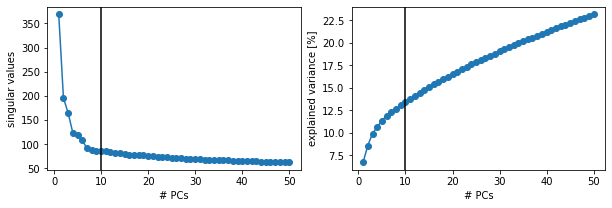

PC4 has correlation with depth of -0.66


In [29]:
m_ind = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP
samples = anno[anno.cellcount==1].index.values

pca_results, umap_results, explained_var = compute_PCA_and_UMAP(
    samples, chrom_order[:-2], m_ind, binary_data=False
)


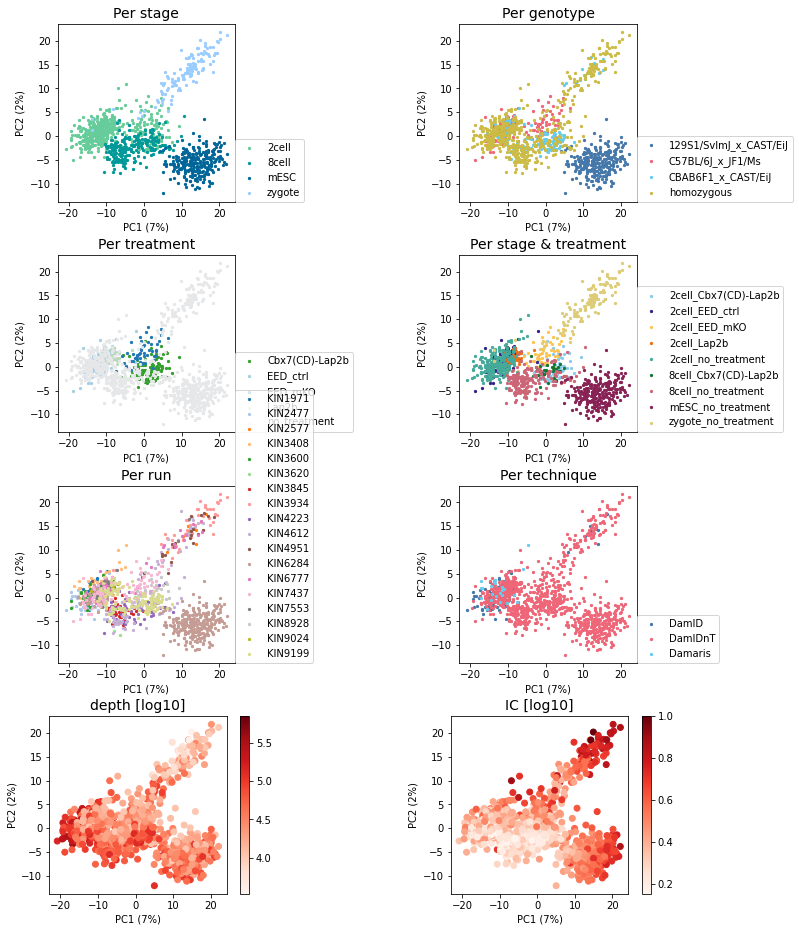

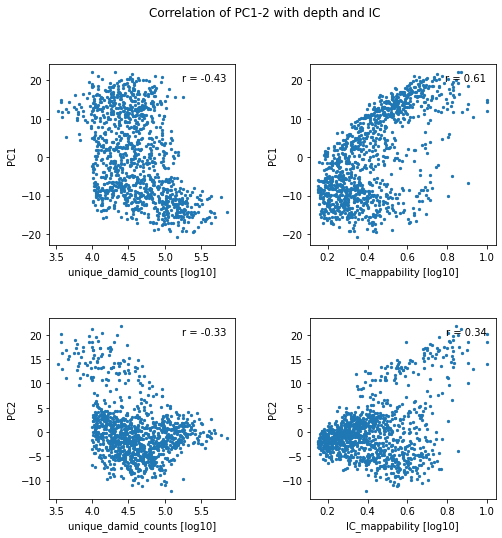

In [30]:
plot_pca_results(pca_results, explained_var)

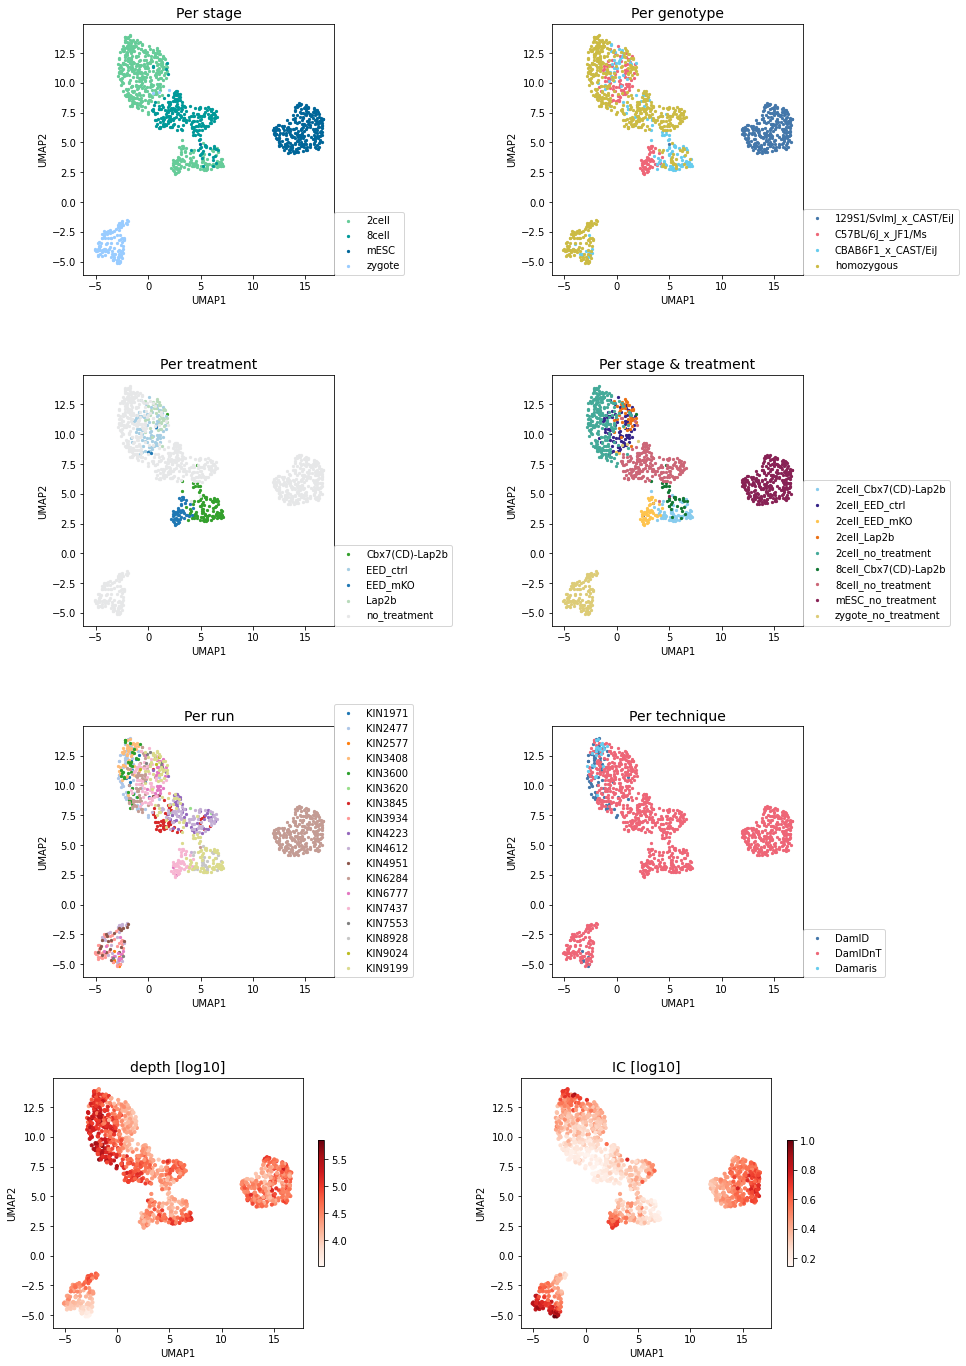

In [31]:
plot_umap_results(umap_results)
outfn = FIGOUTDIR + 'scUMAP.all_conditions.lognorm_data.binsize_%d.pdf' % BINSIZE
plt.savefig(outfn, bbox_inches='tight')

## PCA & UMAP - homozygous embryo samples only - untreated - binary data

In [32]:
# m_ind = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP
# ind = (anno.cellcount==1) & ((~anno.is_heterozygous) | (anno.stage=='mESC')) & (anno.treatment == 'no_treatment')
# samples = anno[ind].index.values

# pca_results, umap_results, explained_var = compute_PCA_and_UMAP(
#     samples, chrom_order[:-2], m_ind
# )

In [33]:
# plot_pca_results(pca_results, explained_var)

In [34]:
# plot_umap_results(umap_results)

# outfn = FIGOUTDIR + 'scUMAP.untreated_homozygous_embryo_and_mESC.binary_data.binsize_%d.pdf' % BINSIZE
# plt.savefig(outfn, bbox_inches='tight')

## PCA & UMAP - untreated homozygous embryo samples only - lognorm data

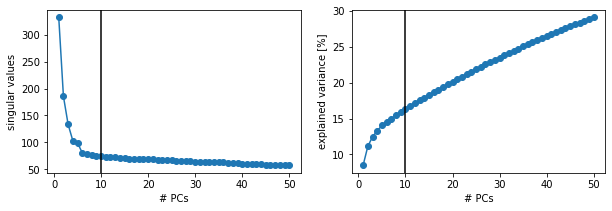

PC1 has correlation with depth of 0.61
PC4 has correlation with depth of -0.59


In [22]:
m_ind = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP
ind = (anno.cellcount==1) & ((~anno.is_heterozygous) | (anno.stage=='mESC')) & (anno.treatment == 'no_treatment')
samples = anno[ind].index.values

pca_results, umap_results, explained_var = compute_PCA_and_UMAP(
    samples, chrom_order[:-2], m_ind, binary_data=False
)

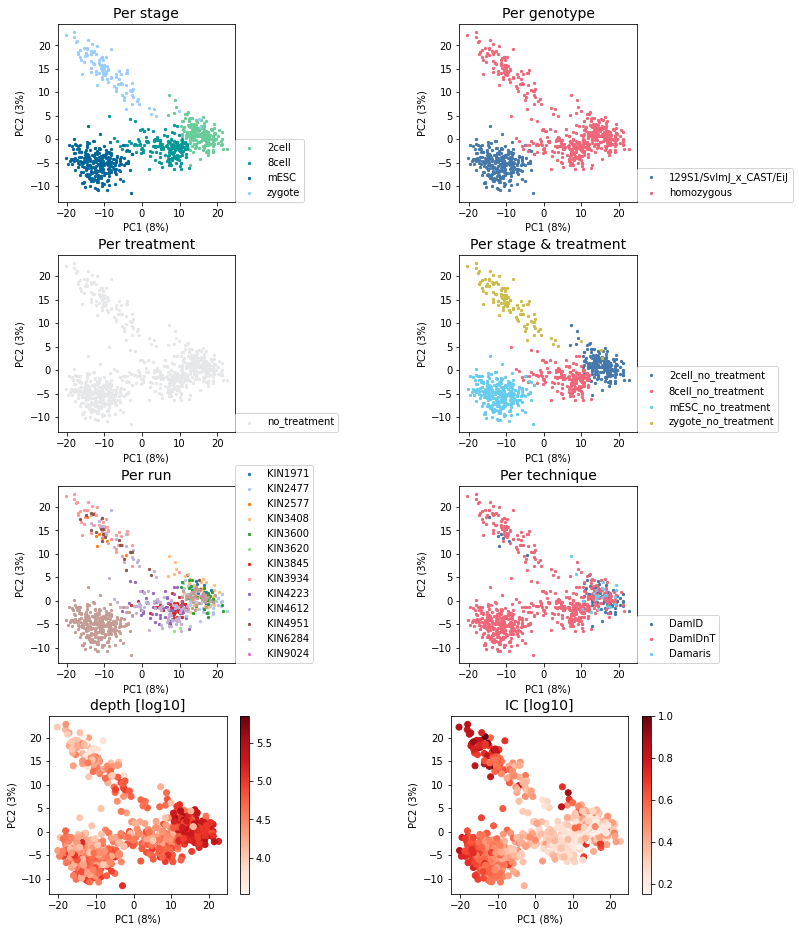

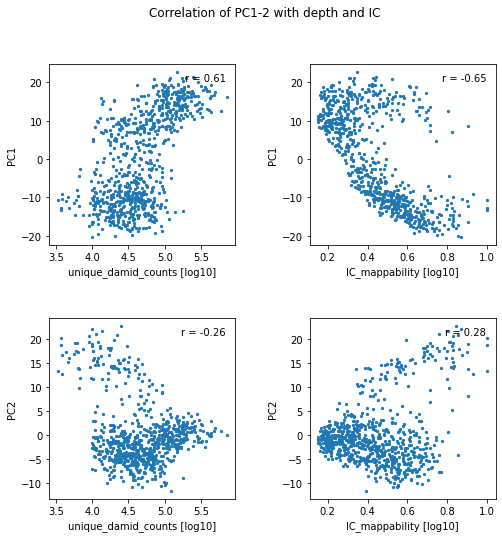

In [36]:
plot_pca_results(pca_results, explained_var)

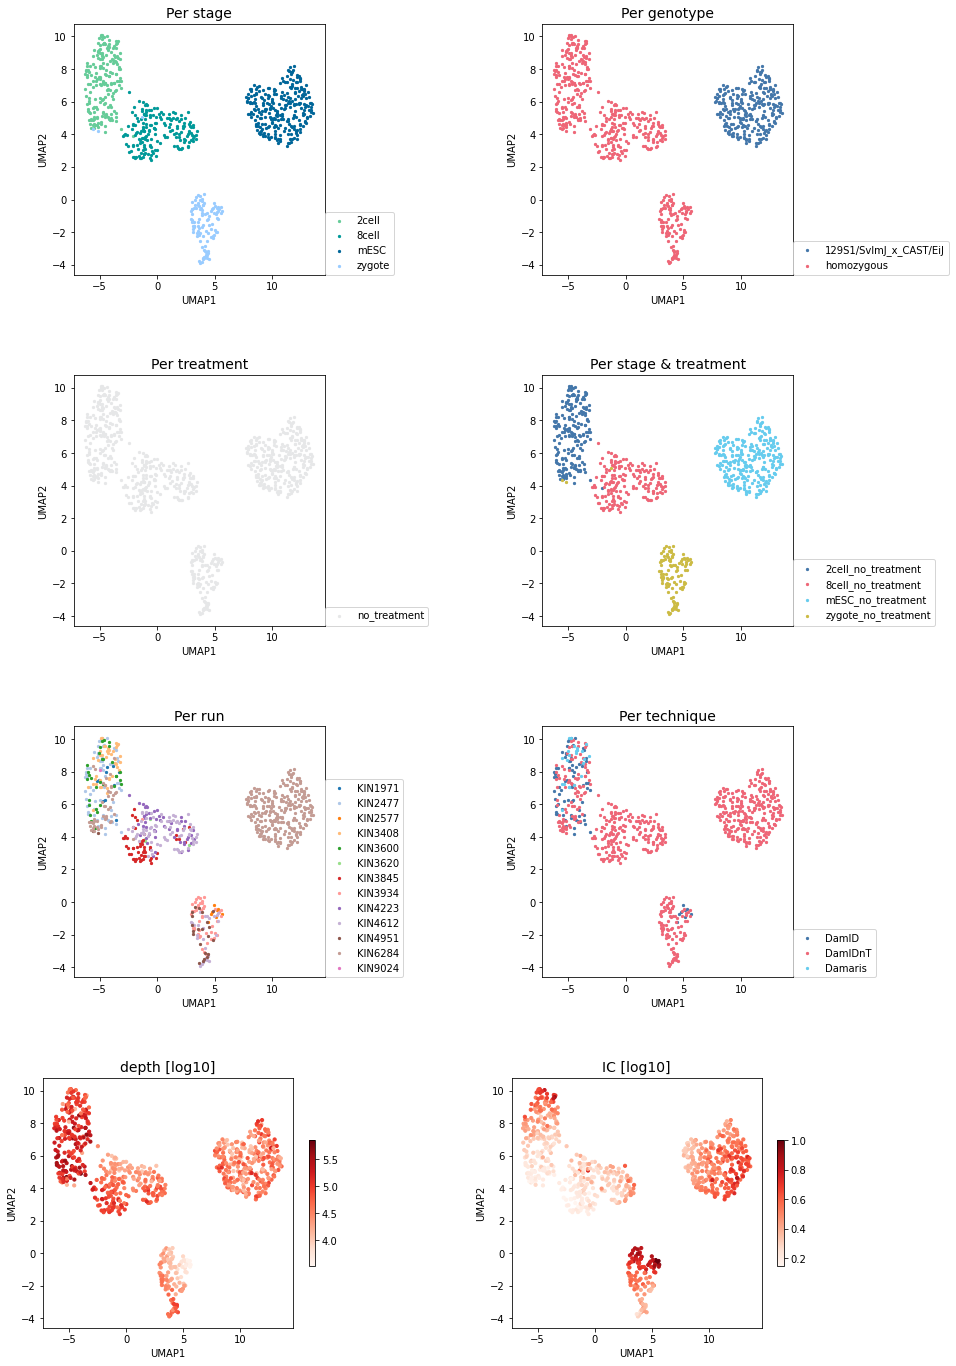

In [37]:
plot_umap_results(umap_results)

outfn = FIGOUTDIR + 'scUMAP.untreated_homozygous_embryo_and_mESC.lognorm_data.binsize_%d.pdf' % BINSIZE
plt.savefig(outfn, bbox_inches='tight')

## PCA & UMAP - hybrid samples only (combined genotype) - binary data

In [38]:
# m_ind = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP

# samples = anno[anno.is_heterozygous & (anno.cellcount==1)].index.values
# pca_results, umap_results, explained_var = compute_PCA_and_UMAP(
#     samples, chrom_order[:-2], m_ind
# )

In [39]:
# plot_pca_results(pca_results, explained_var)

In [40]:
# plot_umap_results(umap_results)

## PCA & UMAP - hybrid samples only (combined genotype) - lognorm data

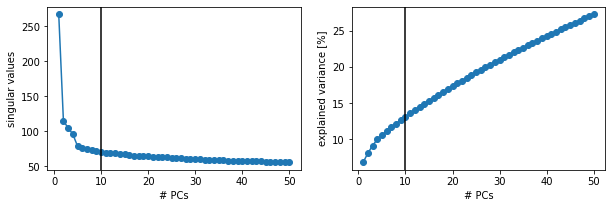

PC4 has correlation with depth of -0.62


In [41]:
m_ind = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP

samples = anno[anno.is_heterozygous & (anno.cellcount==1)].index.values
pca_results, umap_results, explained_var = compute_PCA_and_UMAP(
    samples, chrom_order[:-2], m_ind, binary_data=False
)

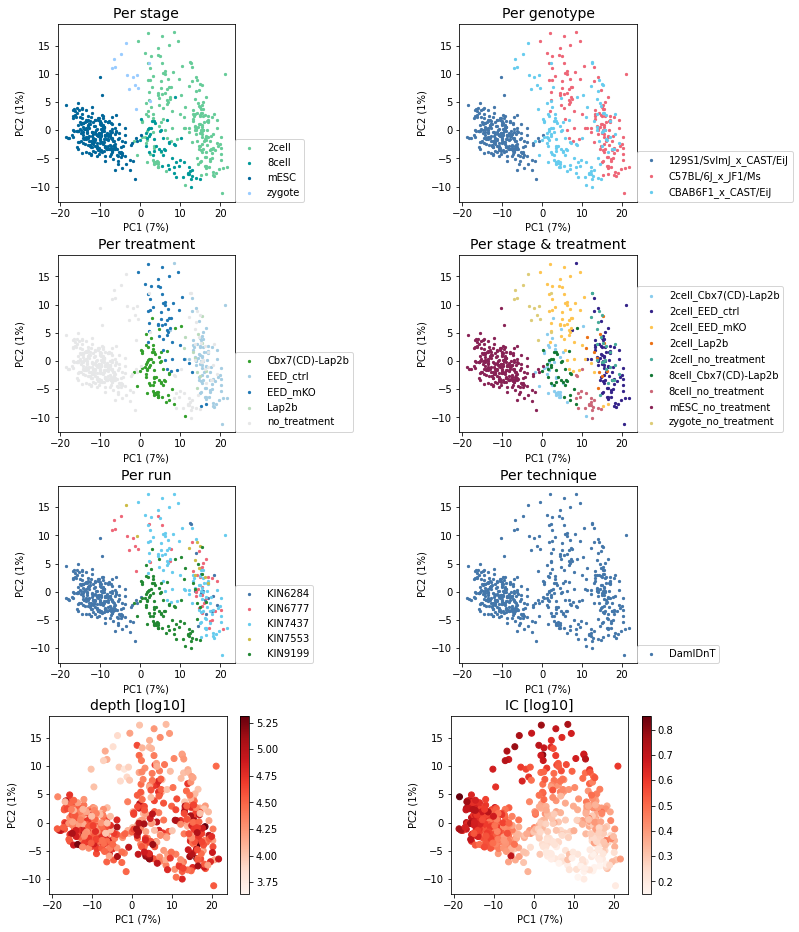

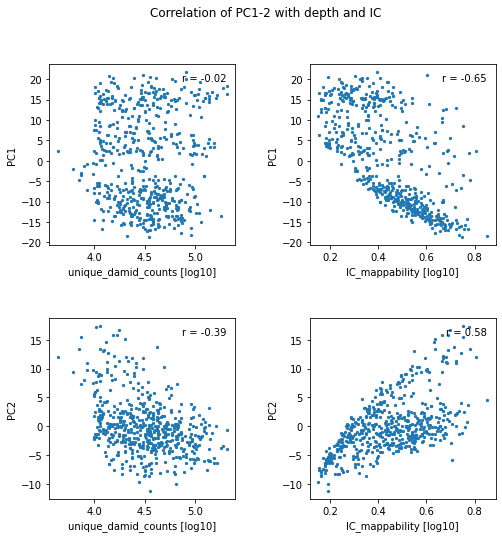

In [42]:
plot_pca_results(pca_results, explained_var)

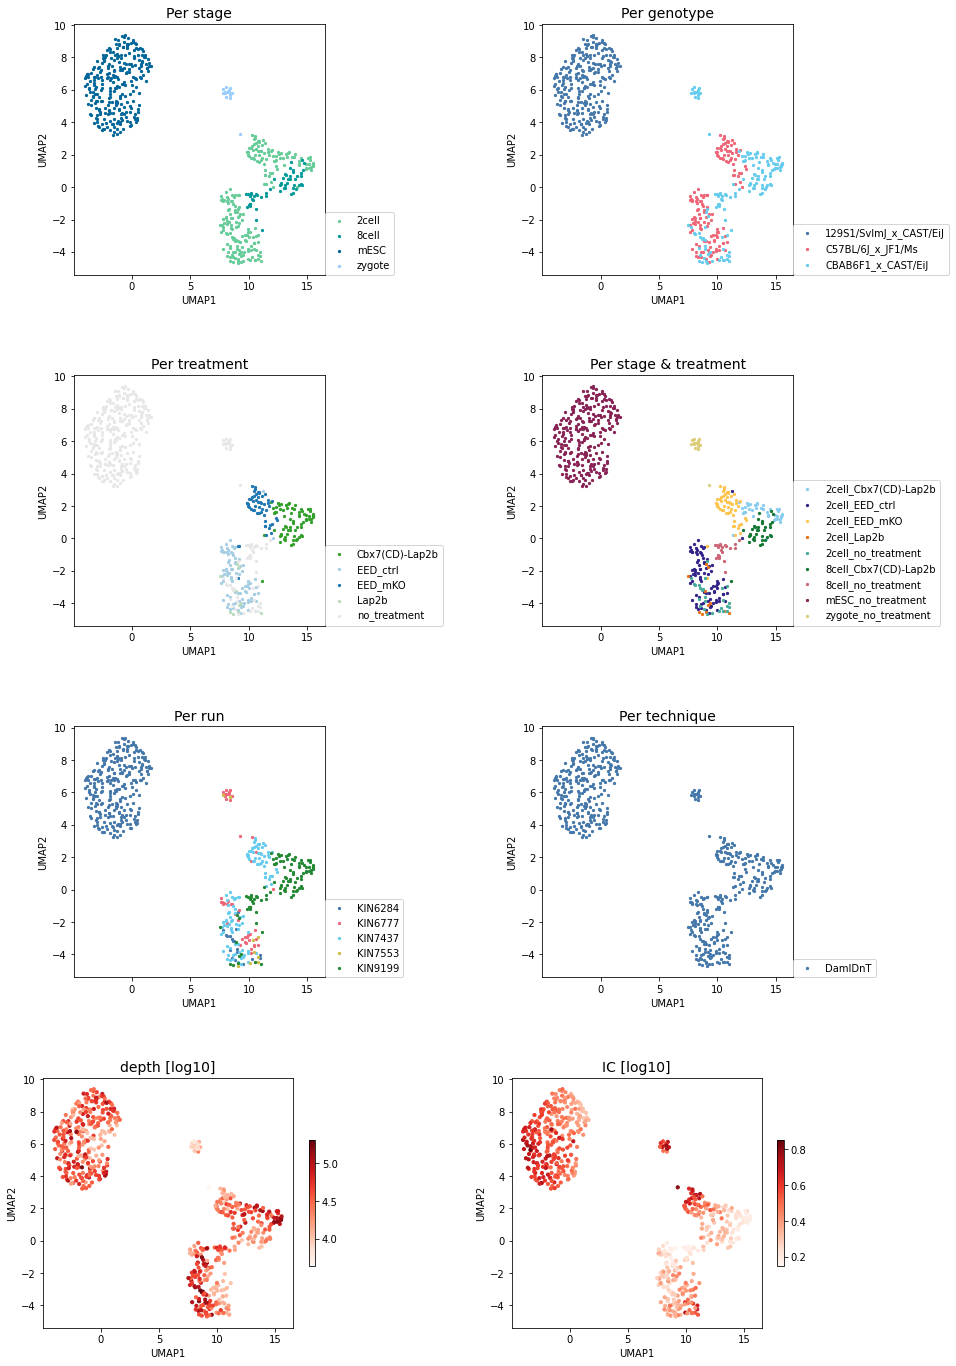

In [43]:
plot_umap_results(umap_results)

## PCA & UMAP - hybrid samples only (maternal genotype) - binary data

In [44]:
# mapab_filt = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP
# al_filt = np.concatenate([allele_filt_total[c] for c in chrom_order[:-2]])
# filt = mapab_filt & al_filt

# samples = anno[anno.is_heterozygous & anno.DamID_PASS_allelic & (anno.cellcount == 1)].index.values
# pca_results, umap_results, explained_var = compute_PCA_and_UMAP(
#     samples, chrom_order[:-2], filt, npc=7, parent='maternal'
# )

In [45]:
# plot_pca_results(pca_results, explained_var)

In [46]:
# plot_umap_results(umap_results)

# outfn = FIGOUTDIR + 'scUMAP.hybrid_embryo_and_mESC.maternal.binary_data.binsize_%d.pdf' % BINSIZE
# plt.savefig(outfn, bbox_inches='tight') 

## PCA & UMAP - hybrid samples only (maternal genotype) - lognorm data

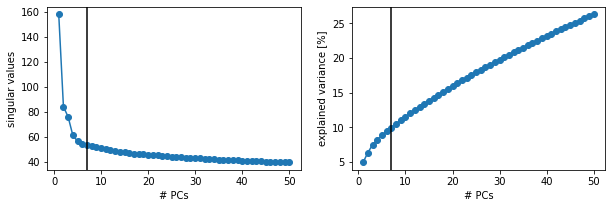

PC3 has correlation with depth of -0.51


In [47]:
mapab_filt = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP
al_filt = np.concatenate([allele_filt_total[c] for c in chrom_order[:-2]])
filt = mapab_filt & al_filt

samples = anno[anno.is_heterozygous & anno.DamID_PASS_allelic & (anno.cellcount == 1)].index.values
pca_results, umap_results, explained_var = compute_PCA_and_UMAP(
    samples, chrom_order[:-2], filt, npc=7, parent='maternal', binary_data=False
)

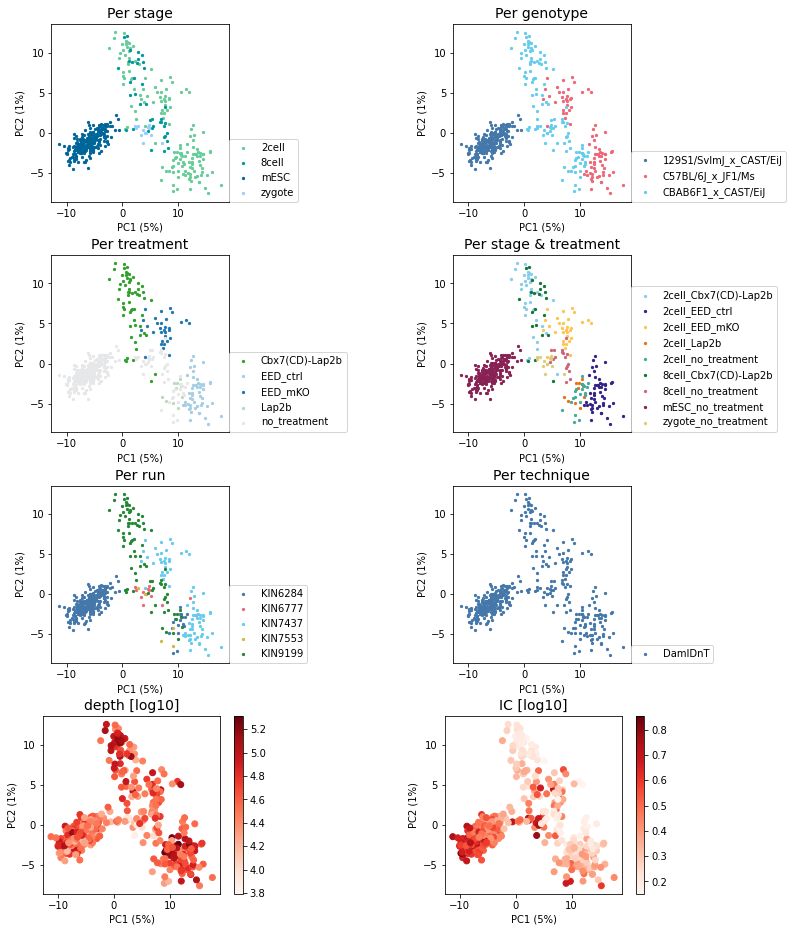

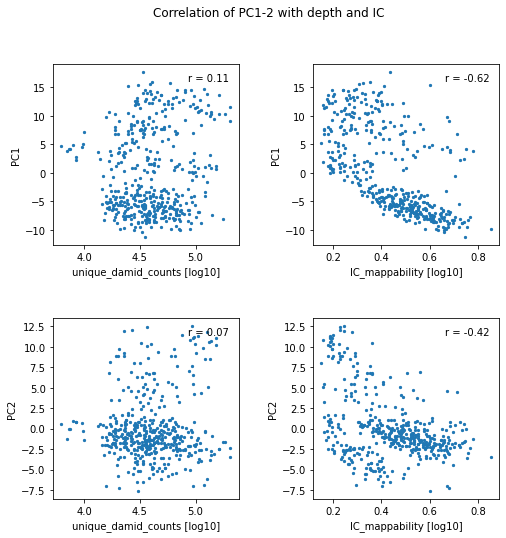

In [48]:
plot_pca_results(pca_results, explained_var)

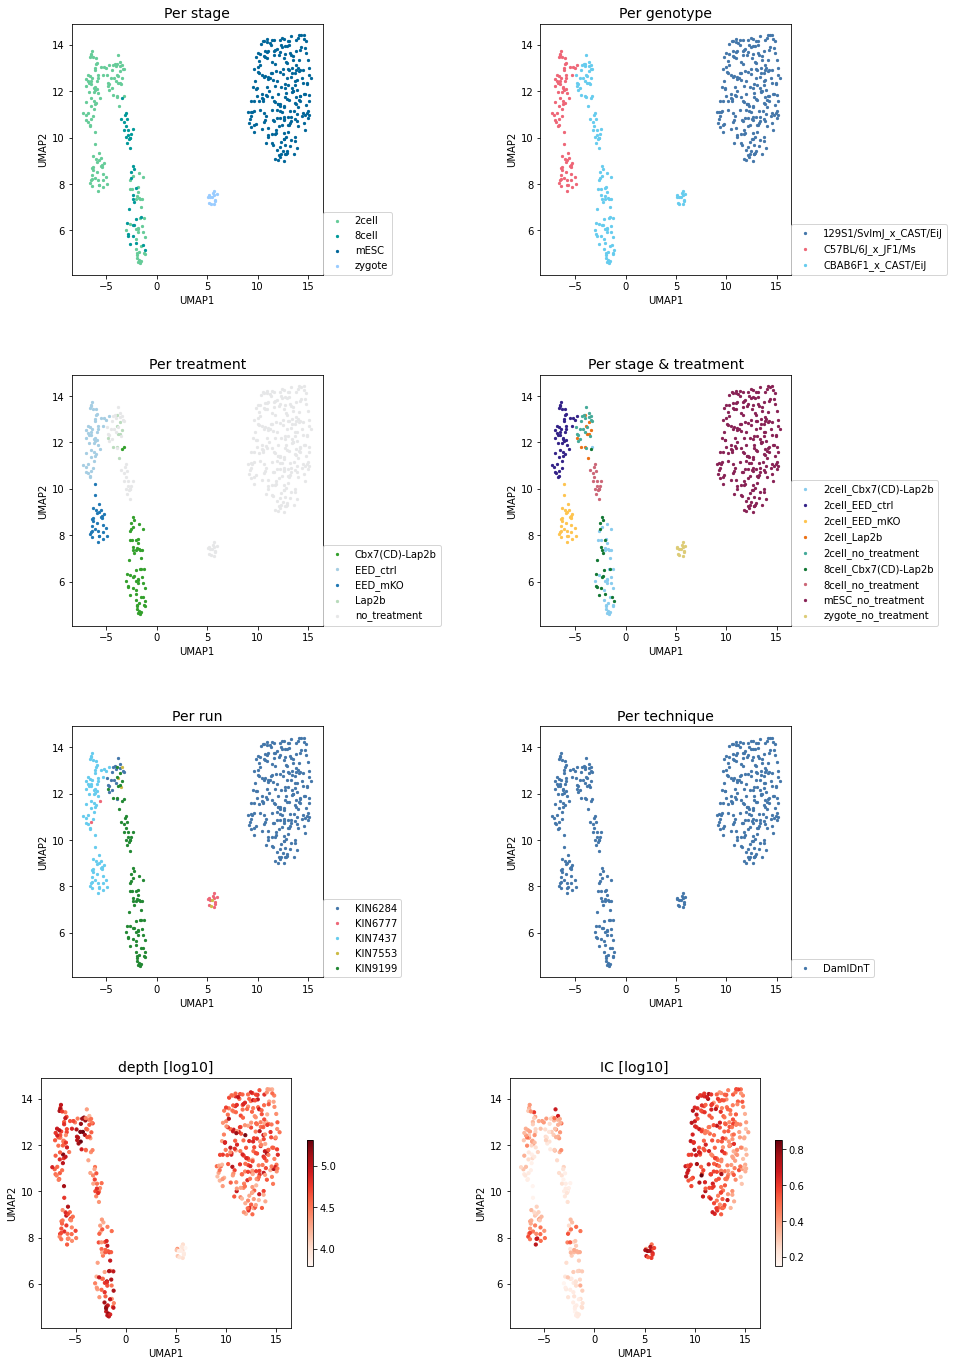

In [49]:
plot_umap_results(umap_results)

outfn = FIGOUTDIR + 'scUMAP.hybrid_embryo_and_mESC.maternal.lognorm_data.binsize_%d.pdf' % BINSIZE
plt.savefig(outfn, bbox_inches='tight') 

## PCA & UMAP - hybrid samples only (paternal genotype) - binary data

In [50]:
# mapab_filt = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP
# al_filt = np.concatenate([allele_filt_total[c] for c in chrom_order[:-2]])
# filt = mapab_filt & al_filt

# samples = anno[anno.is_heterozygous & anno.DamID_PASS_allelic & (anno.cellcount == 1)].index.values
# pca_results, umap_results, explained_var = compute_PCA_and_UMAP(
#     samples, chrom_order[:-2], filt, npc=7, parent='paternal'
# )

In [51]:
# plot_pca_results(pca_results, explained_var)

In [52]:
# plot_umap_results(umap_results)

# outfn = FIGOUTDIR + 'scUMAP.hybrid_embryo_and_mESC.paternal.binary_data.binsize_%d.pdf' % BINSIZE
# plt.savefig(outfn, bbox_inches='tight') 

## PCA & UMAP - hybrid samples only (paternal genotype) - lognorm data

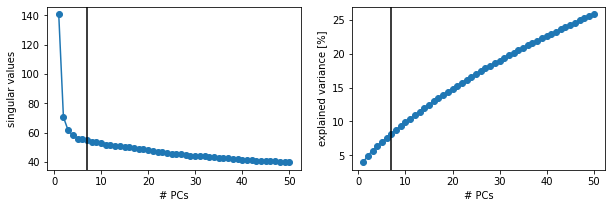

PC3 has correlation with depth of -0.68


In [53]:
mapab_filt = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP
al_filt = np.concatenate([allele_filt_total[c] for c in chrom_order[:-2]])
filt = mapab_filt & al_filt

samples = anno[anno.is_heterozygous & anno.DamID_PASS_allelic & (anno.cellcount == 1)].index.values
pca_results, umap_results, explained_var = compute_PCA_and_UMAP(
    samples, chrom_order[:-2], filt, npc=7, parent='paternal', binary_data=False
)

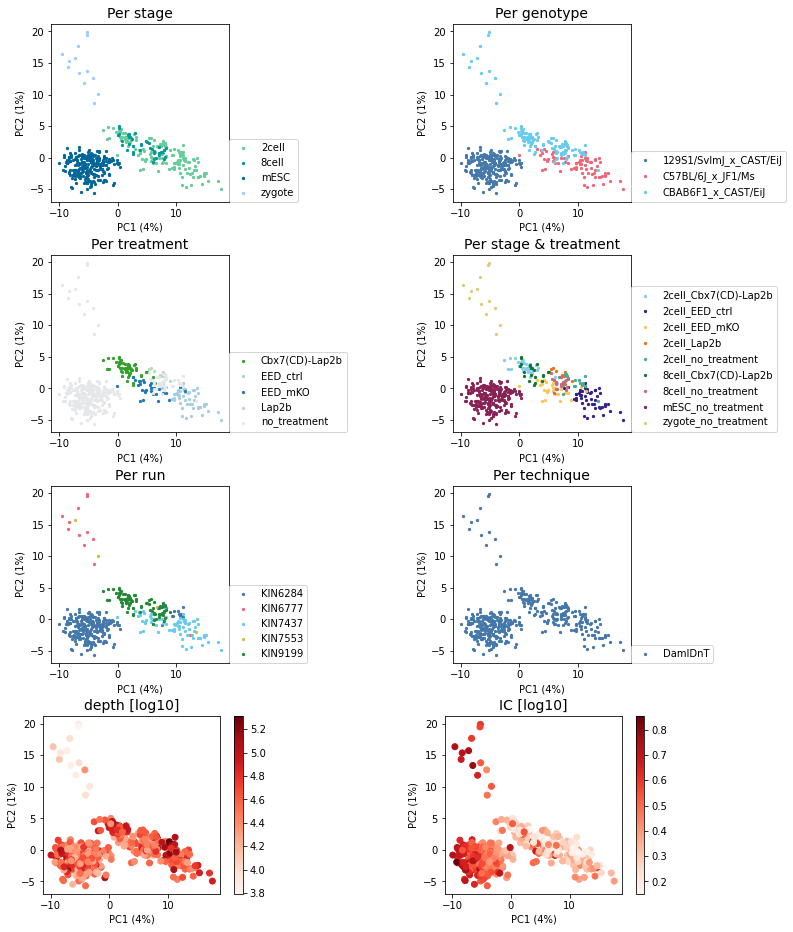

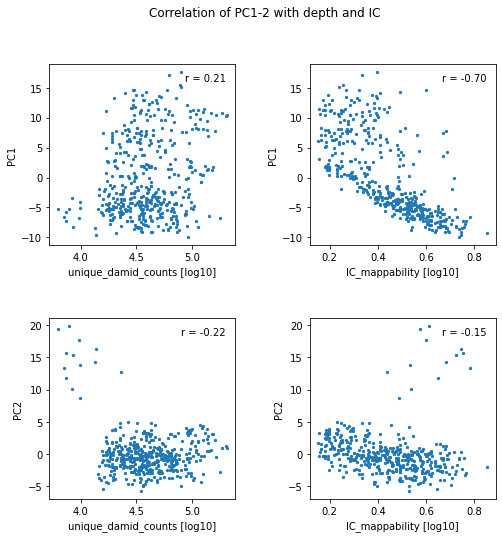

In [54]:
plot_pca_results(pca_results, explained_var)

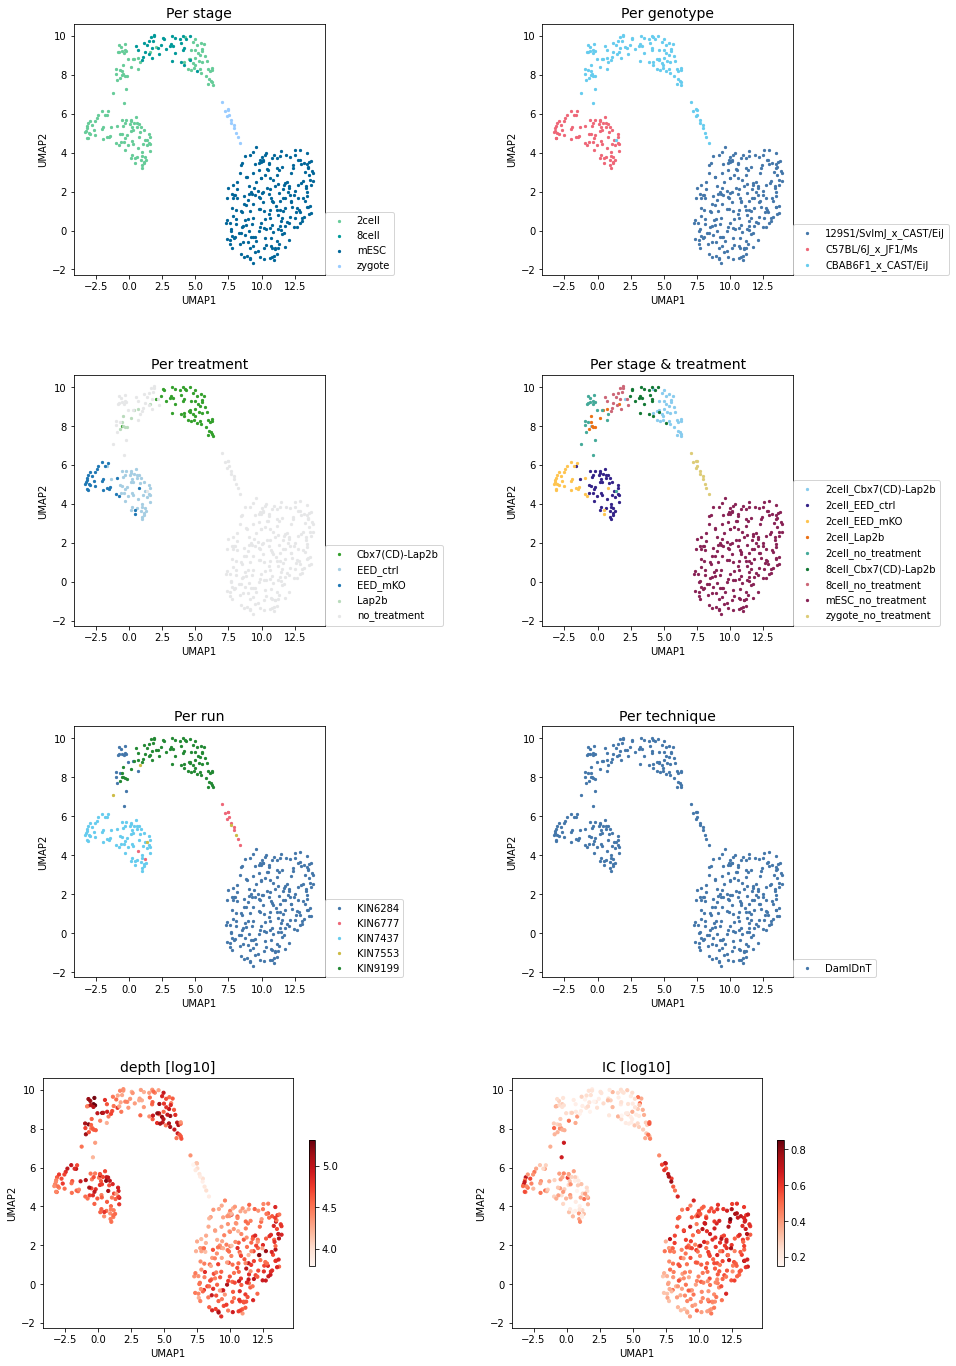

In [55]:
plot_umap_results(umap_results)

outfn = FIGOUTDIR + 'scUMAP.hybrid_embryo_and_mESC.paternal.lognorm_data.binsize_%d.pdf' % BINSIZE
plt.savefig(outfn, bbox_inches='tight') 

# Function to compute PCA and UMAP for joined allele data

In [27]:
def compute_PCA_and_UMAP_joined_alleles(samples, chroms, filt, npc=10, binary_data=True):

    excl_pcs = []
    np.random.seed(1)

    # select data
    data = list()
    not_found = list()
    for parent in ['maternal', 'paternal']:
        for s in samples:
            if s not in damid_binary[parent]:
                print('%s not found for %s' % (s, parent))
                not_found.append(s)
                continue

            if binary_data:
                y = np.concatenate([damid_binary[parent][s][c] for c in chrom_select])[filt]
            else:
                y = np.concatenate([damid_counts[parent][s][c] for c in chrom_select])[filt]
                d = anno.loc[s,'unique_damid_counts'] if parent == 'combined' else anno.loc[s,['maternal_damid_counts', 'paternal_damid_counts']].sum()
                y = np.log1p(y / d * 1e4)
            data.append(y)
    data = np.array(data)
    samples = samples[~np.isin(samples, not_found)]

    # perform PCA
    pca_all = PCA(n_components=50)
    pca_all.fit(data)
    data_transform = pca_all.transform(data)

    # compute correlation of selected PCs with depth
    for pc in range(npc):
        A = data_transform[:,pc]
        B = np.log10(anno.loc[samples, ['maternal_damid_counts', 'paternal_damid_counts']].sum(axis=1).values)
        B = np.concatenate([B,B])
        r, p = stats.pearsonr(A, B)
        if abs(r) > 0.5:
            print('PC%d has correlation with depth of %.2f' % (pc+1, r))
            fig, ax = plt.subplots(figsize=(4,4))
            ax.scatter(A, B, s=5, c='k')
            ax.set_xlabel('PC%d' % (pc+1))
            ax.set_ylabel('depth [log10]')
            ax.set_title('Pearsons R = %.2f' % r)
            plt.show()
            plt.close()


    # format PCA results
    indm = ['%s:maternal' % s for s in samples]
    indp = ['%s:paternal' % s for s in samples]
    ind = np.concatenate([indm, indp])
    pca_results = pd.DataFrame(data_transform[:,:4], columns=['PC1', 'PC2', 'PC3', 'PC4'], index=ind)
    cols = ['runid', 'cellcount', 'stage', 'induction_system', 'genotype', 'treatment', 'number_embryos', 'technique', 'unique_damid_counts', 'IC_mappability']

    tmp = anno.loc[samples,cols].copy()
    tmp['parent'] = 'maternal'
    tmp2 = tmp.copy()
    tmp2['parent'] = 'paternal'
    tmp = pd.concat([tmp, tmp2], axis=0)
    tmp = tmp.set_index(ind)
    pca_results = pd.concat([pca_results, tmp], axis=1)

    explained_var = pca_all.explained_variance_ratio_
    singular_vals = pca_all.singular_values_

    # visualize explained variance
    fig, ax = plt.subplots(figsize=(5,3))
    X = np.arange(len(explained_var)) + 1
    Y = singular_vals

    ax.plot(X, Y, 'o-')
    ax.axvline(npc, c='k')
    plt.show()
    plt.close()

    # compute UMAP
    select_pcs = np.arange(npc)
    if len(excl_pcs) > 0:
        select_pcs = select_pcs[~np.isin(select_pcs, excl_pcs)]
    print('Using PCs: ', select_pcs)
    data_embedded = UMAP(random_state=1, min_dist=.5).fit_transform(data_transform[:,select_pcs])

    # format UMAP results
    umap_results = pd.DataFrame(data_embedded, columns=['UMAP1', 'UMAP2'], index=ind)
    cols = ['runid', 'cellcount', 'stage', 'induction_system', 'genotype', 'treatment', 'number_embryos', 'technique', 'unique_damid_counts', 'IC_mappability', 'sex']

    tmp = anno.loc[samples,cols].copy()
    tmp['parent'] = 'maternal'
    tmp2 = tmp.copy()
    tmp2['parent'] = 'paternal'
    tmp = pd.concat([tmp, tmp2], axis=0)
    tmp = tmp.set_index(ind)
    umap_results = pd.concat([umap_results, tmp], axis=1)
    
    
    return pca_results, umap_results, explained_var

# Joined allele UMAP - all untreaded hybrid samples

PC2 has correlation with depth of -0.70


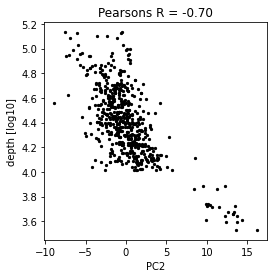

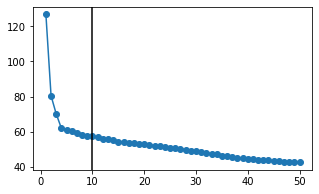

Using PCs:  [0 1 2 3 4 5 6 7 8 9]


In [57]:
chrom_select = np.array(chrom_order[:-2])
chrom_select = chrom_select[chrom_select != '12']

ind = anno.is_heterozygous & anno.DamID_PASS_allelic & (anno.cellcount==1) & (anno.treatment == 'no_treatment')
samples = anno[ind].index.values

filt = np.concatenate([mapab[c] for c in chrom_select]) > MINMAP
for gt in anno.loc[samples,'genotype'].unique():
    gt_filt = np.concatenate([allele_filt_gt[gt][c] for c in chrom_select])
    filt = filt & gt_filt

binary_data = False

pca_results, umap_results, explained_var = compute_PCA_and_UMAP_joined_alleles(
    samples, chrom_select, filt, npc=10, binary_data=binary_data
)

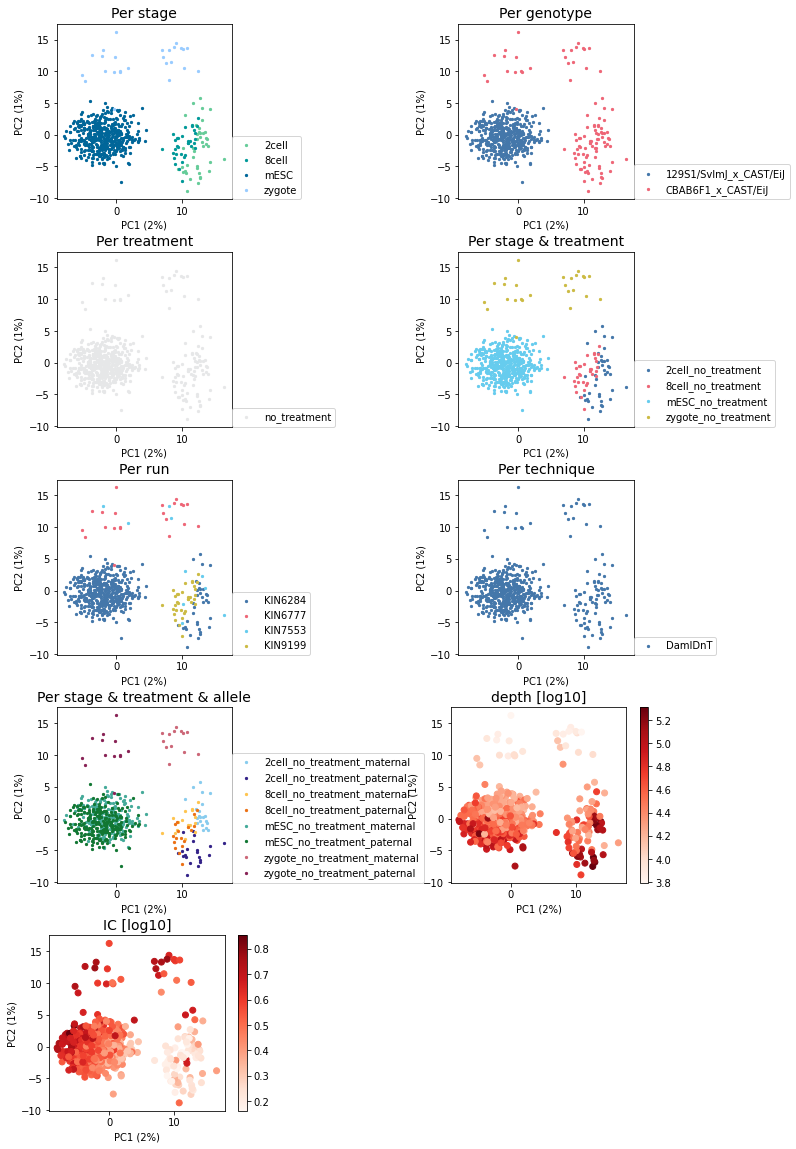

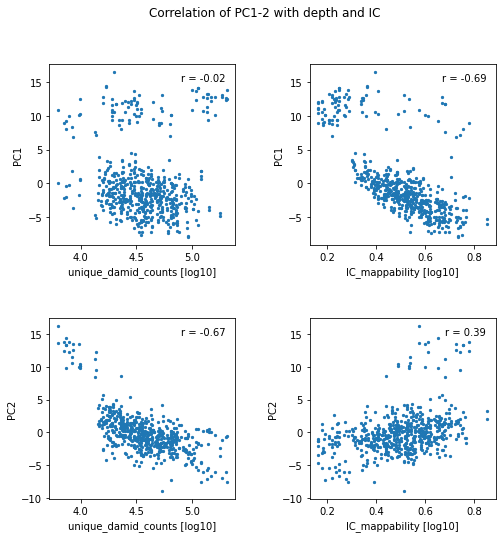

In [58]:
pca_results['stage_treatment_parent'] = pca_results.apply(axis=1, func = lambda r: '%s_%s_%s' % (r['stage'], r['treatment'], r['parent']))
plot_pca_results(pca_results, explained_var, additional_cols={'Per stage & treatment & allele': 'stage_treatment_parent'})

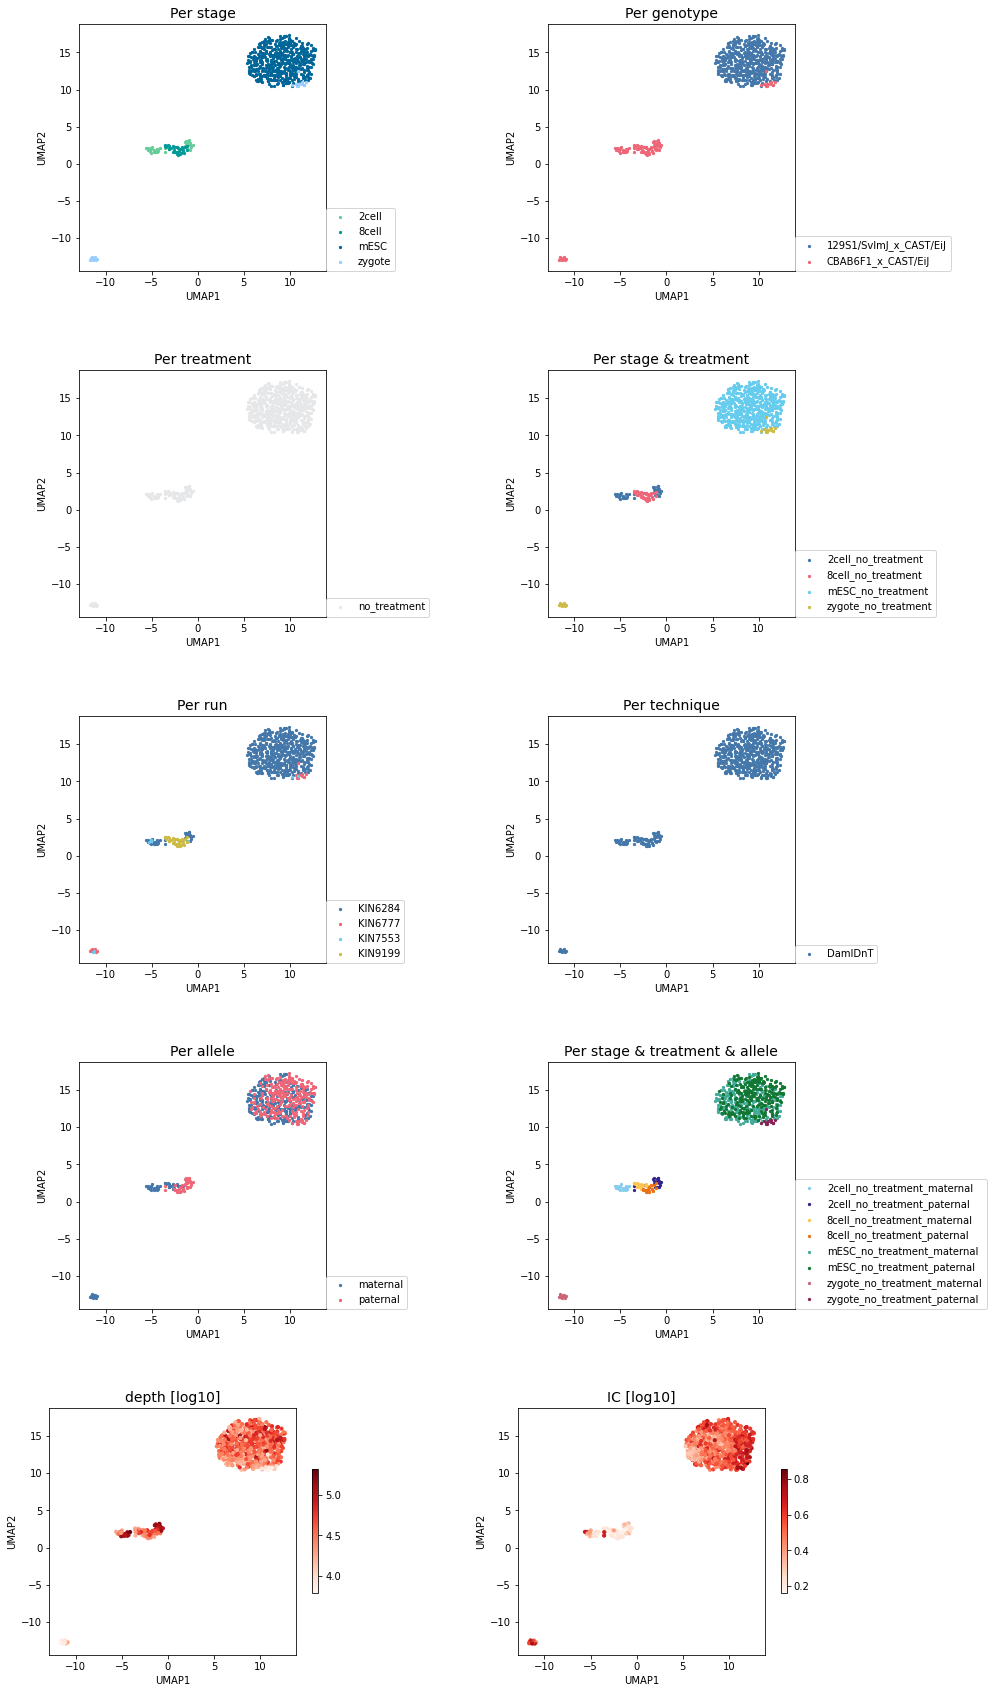

In [59]:
umap_results['stage_treatment_parent'] = umap_results.apply(axis=1, func = lambda r: '%s_%s_%s' % (r['stage'], r['treatment'], r['parent']))

plot_umap_results(umap_results, additional_cols={'Per allele': 'parent', 'Per stage & treatment & allele': 'stage_treatment_parent'})

outfn = FIGOUTDIR + 'scUMAP_joined_alleles.untreated_hybrid_embryo_and_mESC.lognorm_data.binsize_%d.pdf' % BINSIZE
if binary_data:
    outfn = outfn.replace('lognorm', 'binary')

plt.savefig(outfn, bbox_inches='tight')

# Joined allele UMAP - all hybrid samples

PC3 has correlation with depth of -0.57


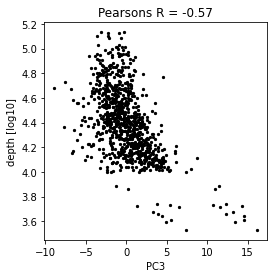

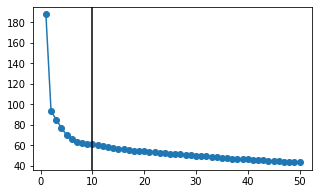

Using PCs:  [0 1 2 3 4 5 6 7 8 9]


In [60]:
chrom_select = np.array(chrom_order[:-2])
chrom_select = chrom_select[chrom_select != '12']

ind = anno.is_heterozygous & anno.DamID_PASS_allelic & (anno.cellcount==1)
samples = anno[ind].index.values

filt = np.concatenate([mapab[c] for c in chrom_select]) > MINMAP
for gt in anno.loc[samples,'genotype'].unique():
    gt_filt = np.concatenate([allele_filt_gt[gt][c] for c in chrom_select])
    filt = filt & gt_filt

binary_data = False

pca_results, umap_results, explained_var = compute_PCA_and_UMAP_joined_alleles(
    samples, chrom_select, filt, npc=10, binary_data=binary_data
)

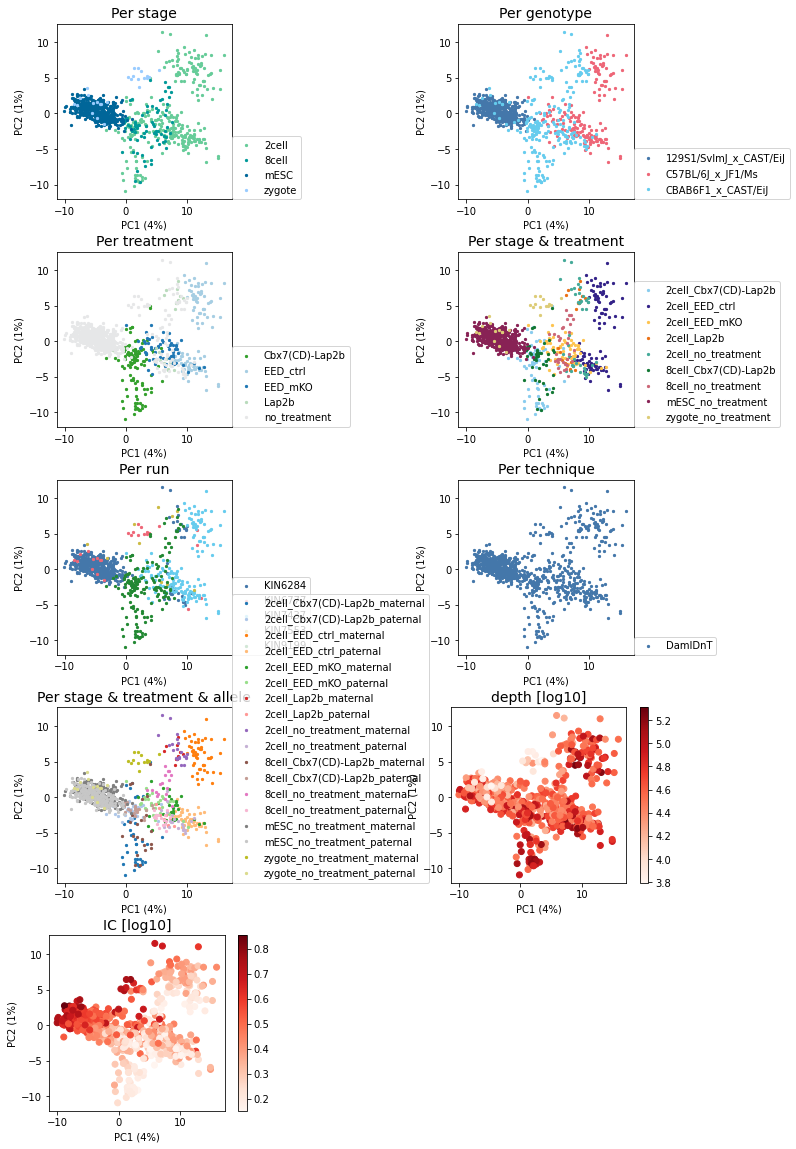

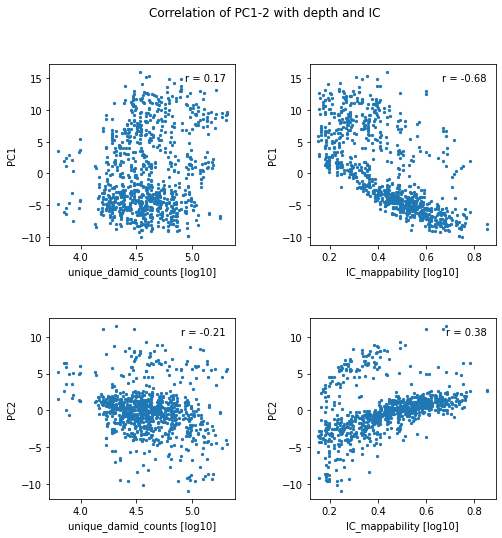

In [61]:
pca_results['stage_treatment_parent'] = pca_results.apply(axis=1, func = lambda r: '%s_%s_%s' % (r['stage'], r['treatment'], r['parent']))
plot_pca_results(pca_results, explained_var, additional_cols={'Per stage & treatment & allele': 'stage_treatment_parent'})

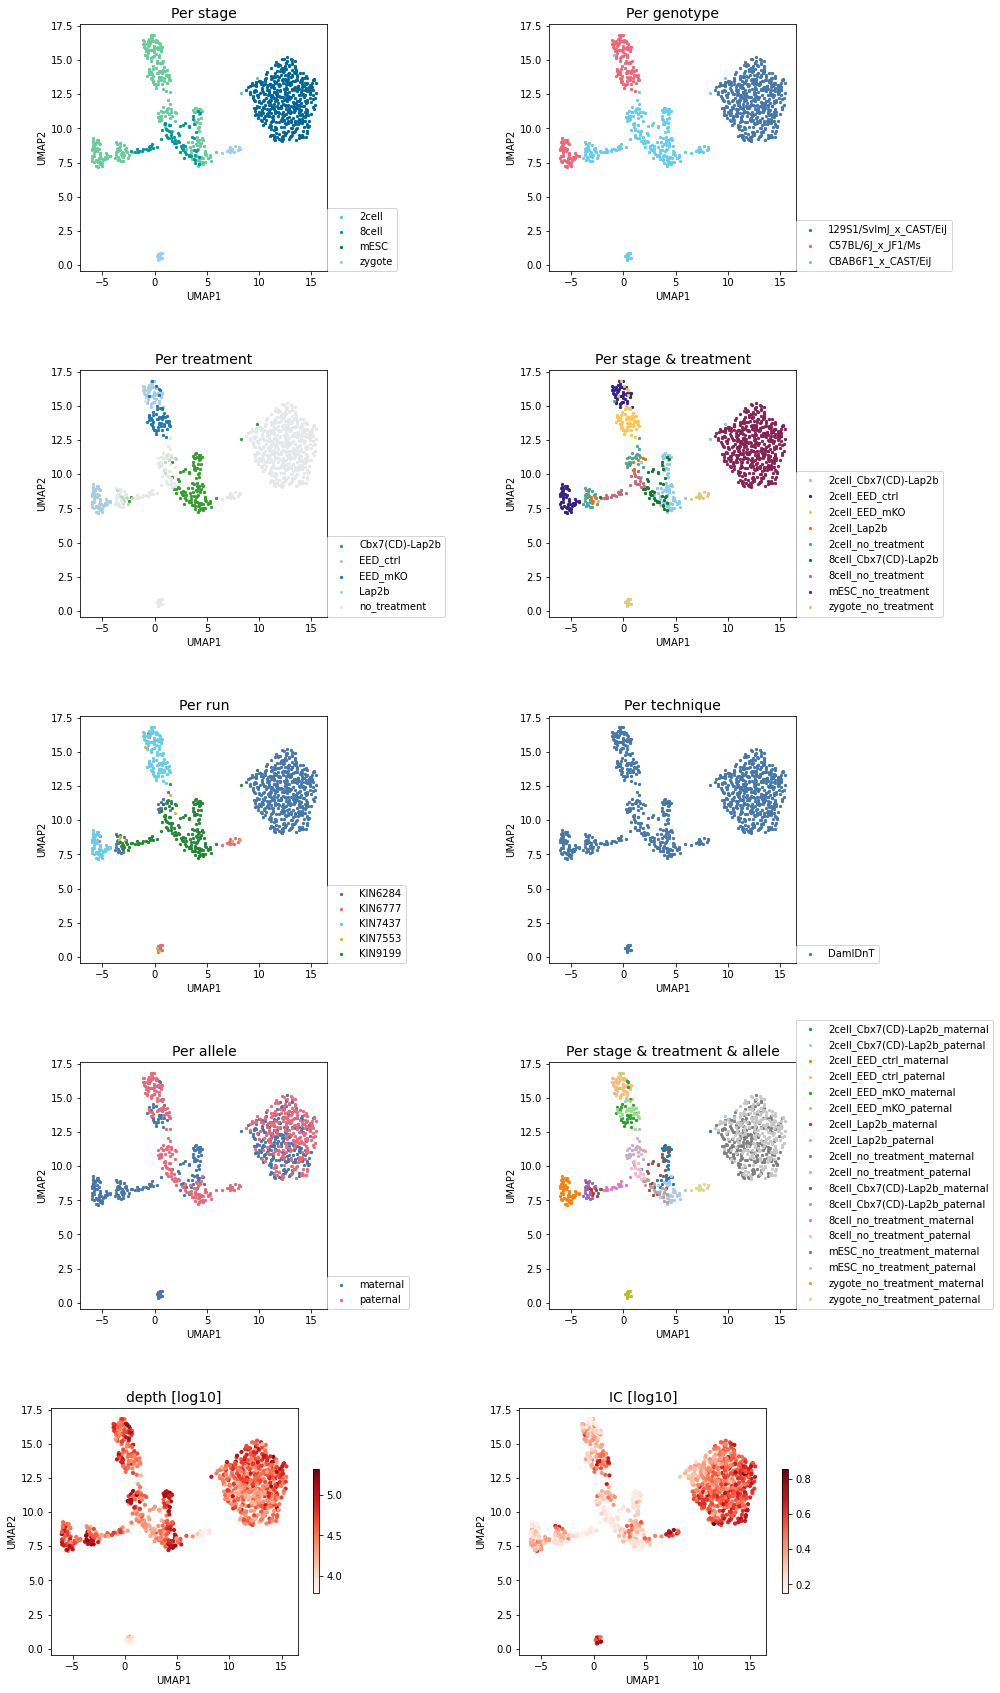

In [62]:
umap_results['stage_treatment_parent'] = umap_results.apply(axis=1, func = lambda r: '%s_%s_%s' % (r['stage'], r['treatment'], r['parent']))

plot_umap_results(umap_results, additional_cols={'Per allele': 'parent', 'Per stage & treatment & allele': 'stage_treatment_parent'})

outfn = FIGOUTDIR + 'scUMAP_joined_alleles.all_hybrid_embryo_and_mESC.lognorm_data.binsize_%d.pdf' % BINSIZE
if binary_data:
    outfn = outfn.replace('lognorm', 'binary')

plt.savefig(outfn, bbox_inches='tight')

# Joined allele UMAP - all 2cell hybrid samples

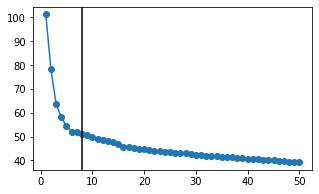

Using PCs:  [0 1 2 3 4 5 6 7]


In [63]:
chrom_select = np.array(chrom_order[:-2])

ind = anno.is_heterozygous & anno.DamID_PASS_allelic & (anno.cellcount==1) & (anno.stage == '2cell')
samples = anno[ind].index.values

filt = np.concatenate([mapab[c] for c in chrom_select]) > MINMAP
for gt in anno.loc[samples,'genotype'].unique():
    gt_filt = np.concatenate([allele_filt_gt[gt][c] for c in chrom_select])
    filt = filt & gt_filt

binary_data = False

pca_results, umap_results, explained_var = compute_PCA_and_UMAP_joined_alleles(
    samples, chrom_select, filt, npc=8, binary_data=binary_data
)

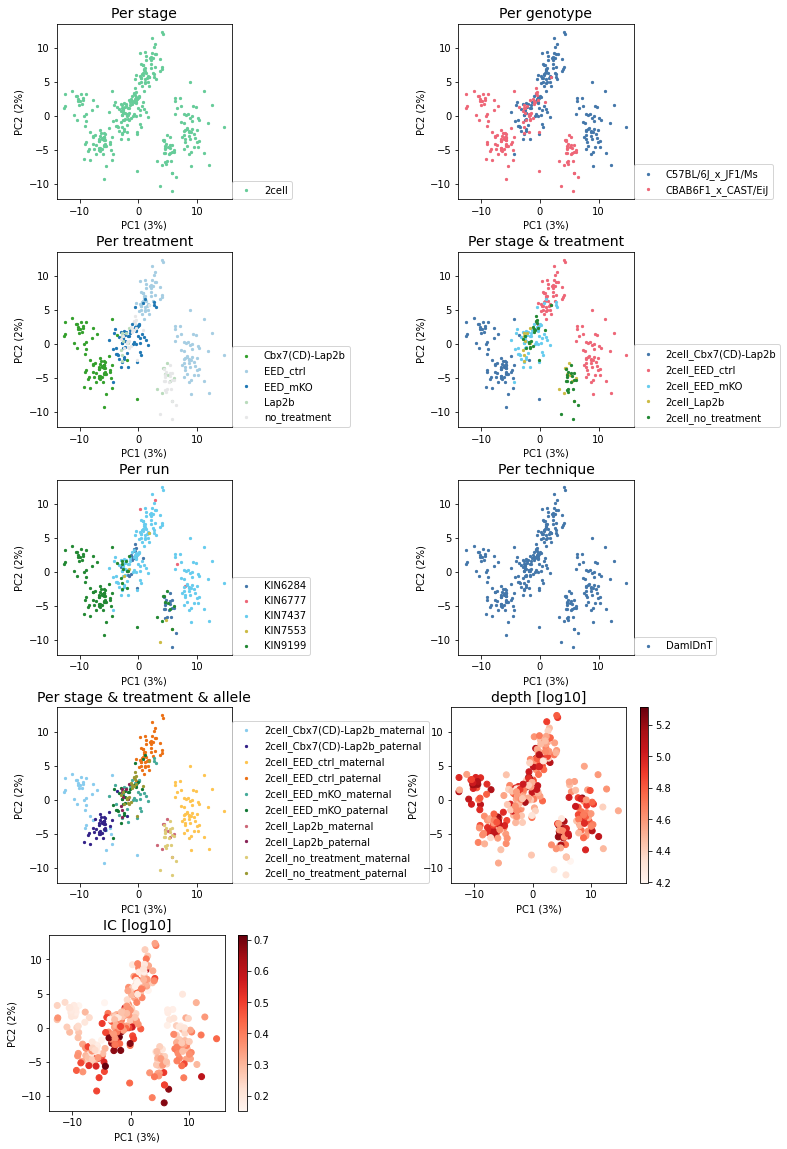

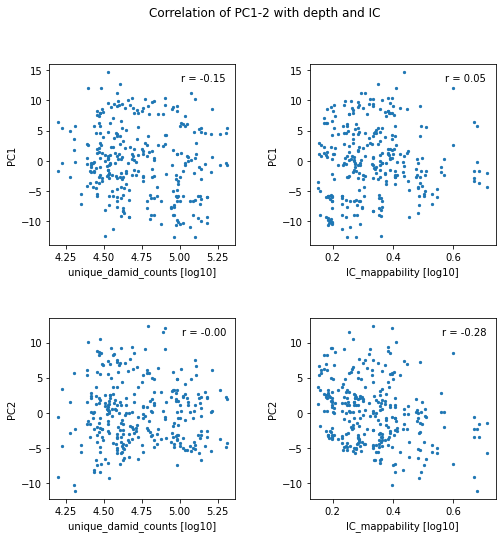

In [64]:
pca_results['stage_treatment_parent'] = pca_results.apply(axis=1, func = lambda r: '%s_%s_%s' % (r['stage'], r['treatment'], r['parent']))
plot_pca_results(pca_results, explained_var, additional_cols={'Per stage & treatment & allele': 'stage_treatment_parent'})

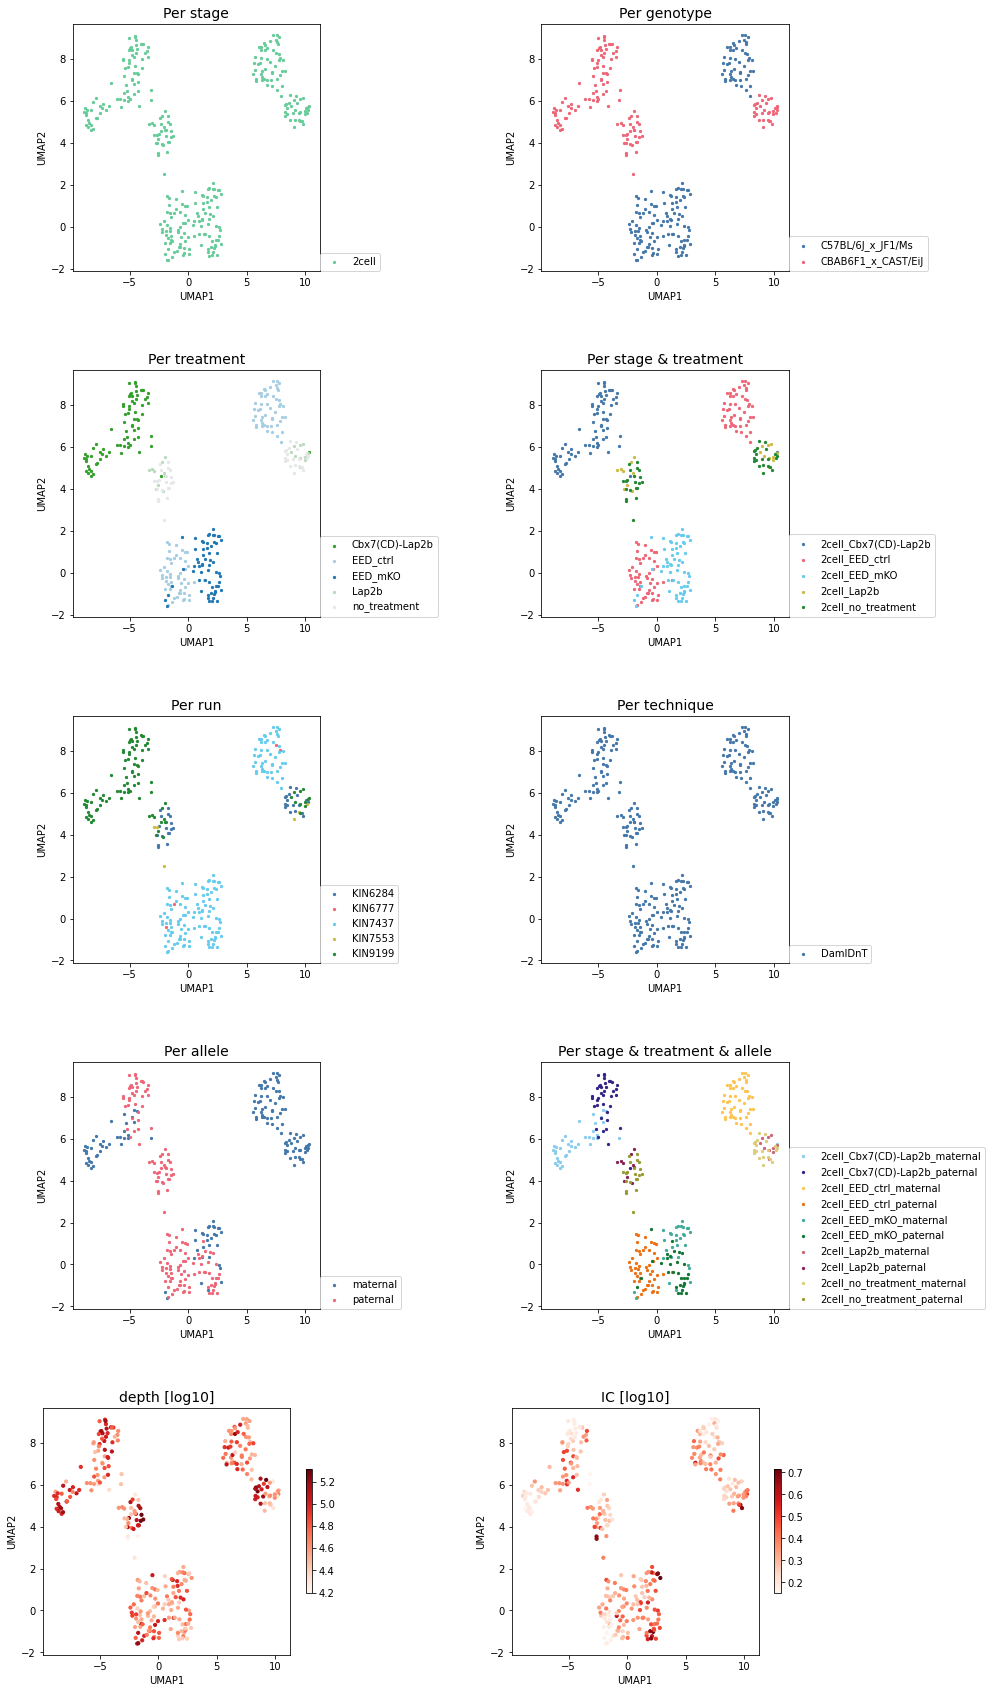

In [65]:
umap_results['stage_treatment_parent'] = umap_results.apply(axis=1, func = lambda r: '%s_%s_%s' % (r['stage'], r['treatment'], r['parent']))

plot_umap_results(umap_results, additional_cols={'Per allele': 'parent', 'Per stage & treatment & allele': 'stage_treatment_parent'})

outfn = FIGOUTDIR + 'scUMAP_joined_alleles.2cell_hybrid_embryo.lognorm_data.binsize_%d.pdf' % BINSIZE
if binary_data:
    outfn = outfn.replace('lognorm', 'binary')

plt.savefig(outfn, bbox_inches='tight')

# Joined allele UMAP - 2cell hybrid samples: WT and EED experiment

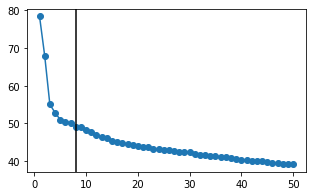

Using PCs:  [0 1 2 3 4 5 6 7]


In [28]:
chrom_select = np.array(chrom_order[:-2])

ind = anno.is_heterozygous & anno.DamID_PASS_allelic & (anno.cellcount==1) & (anno.stage == '2cell') & (anno.treatment.isin(['no_treatment', 'EED_ctrl', 'EED_mKO']))
samples = anno[ind].index.values

filt = np.concatenate([mapab[c] for c in chrom_select]) > MINMAP
for gt in anno.loc[samples,'genotype'].unique():
    gt_filt = np.concatenate([allele_filt_gt[gt][c] for c in chrom_select])
    filt = filt & gt_filt

binary_data = False

pca_results, umap_results, explained_var = compute_PCA_and_UMAP_joined_alleles(
    samples, chrom_select, filt, npc=8, binary_data=binary_data
)

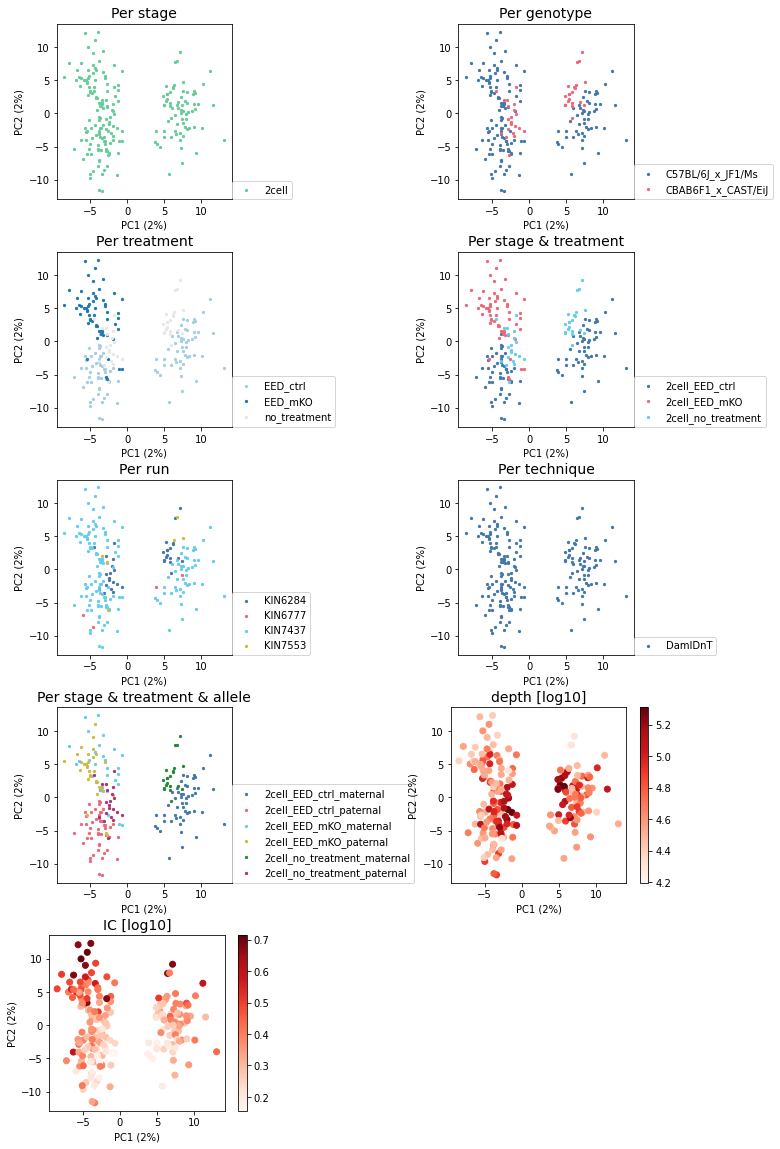

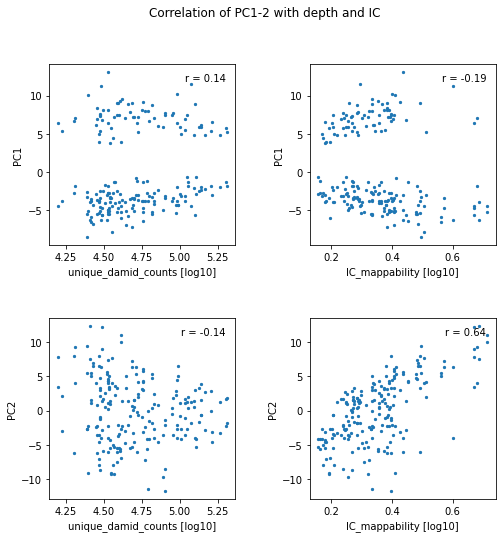

In [29]:
pca_results['stage_treatment_parent'] = pca_results.apply(axis=1, func = lambda r: '%s_%s_%s' % (r['stage'], r['treatment'], r['parent']))
plot_pca_results(pca_results, explained_var, additional_cols={'Per stage & treatment & allele': 'stage_treatment_parent'})

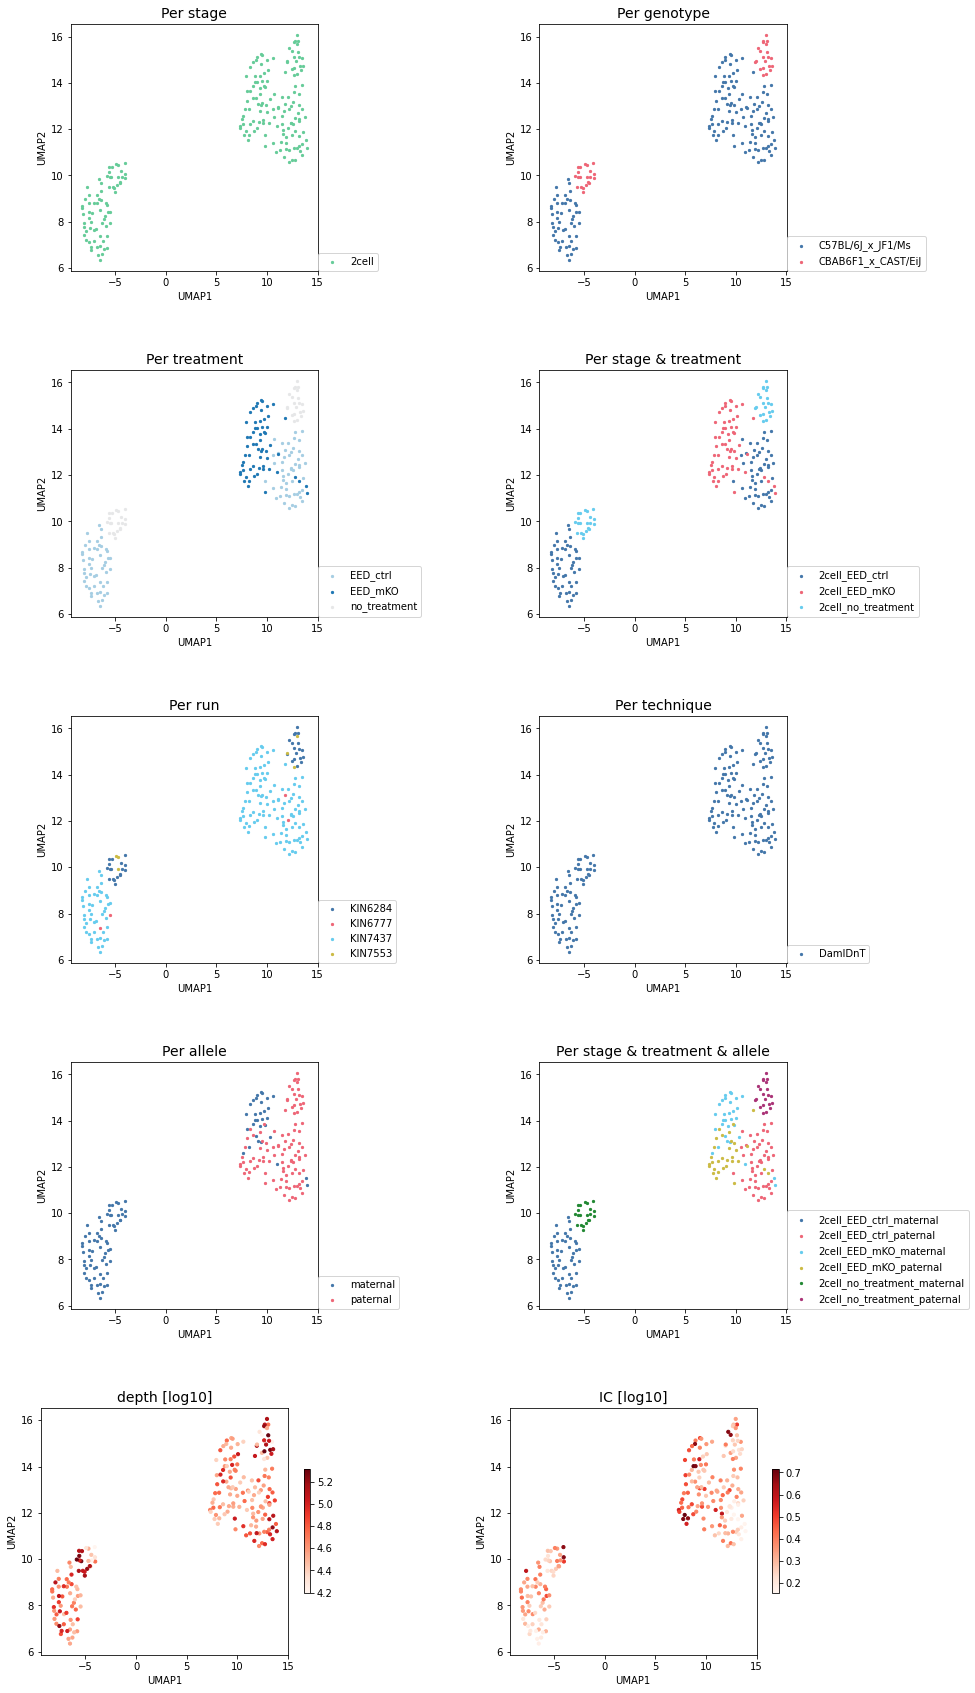

In [31]:
umap_results['stage_treatment_parent'] = umap_results.apply(axis=1, func = lambda r: '%s_%s_%s' % (r['stage'], r['treatment'], r['parent']))

plot_umap_results(umap_results, additional_cols={'Per allele': 'parent', 'Per stage & treatment & allele': 'stage_treatment_parent'})

outfn = FIGOUTDIR + 'scUMAP_joined_alleles.2cell_hybrid_embryo.EED_and_WT.lognorm_data.binsize_%d.pdf' % BINSIZE
if binary_data:
    outfn = outfn.replace('lognorm', 'binary')

plt.savefig(outfn, bbox_inches='tight')

# Joined allele UMAP - 2cell/8cell embryo hybrid samples

PC4 has correlation with depth of -0.52


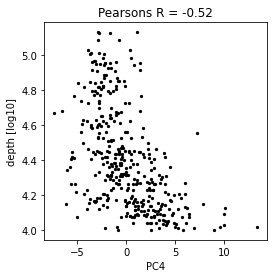

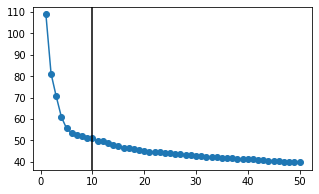

Using PCs:  [0 1 2 3 4 5 6 7 8 9]


In [66]:
chrom_select = np.array(chrom_order[:-2])

ind = anno.is_heterozygous & anno.DamID_PASS_allelic & (anno.cellcount==1) & anno.stage.isin(['2cell','8cell'])
samples = anno[ind].index.values

filt = np.concatenate([mapab[c] for c in chrom_select]) > MINMAP
for gt in anno.loc[samples,'genotype'].unique():
    gt_filt = np.concatenate([allele_filt_gt[gt][c] for c in chrom_select])
    filt = filt & gt_filt

binary_data = False

pca_results, umap_results, explained_var = compute_PCA_and_UMAP_joined_alleles(
    samples, chrom_select, filt, npc=10, binary_data=binary_data
)

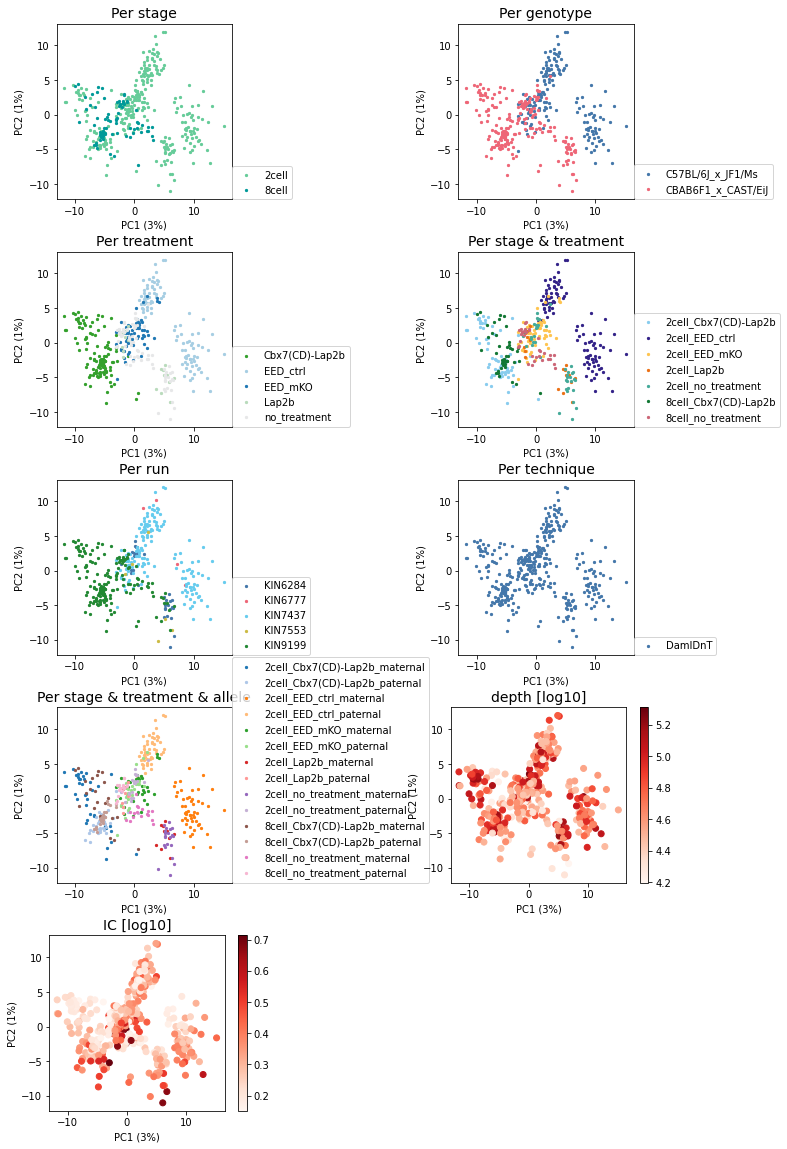

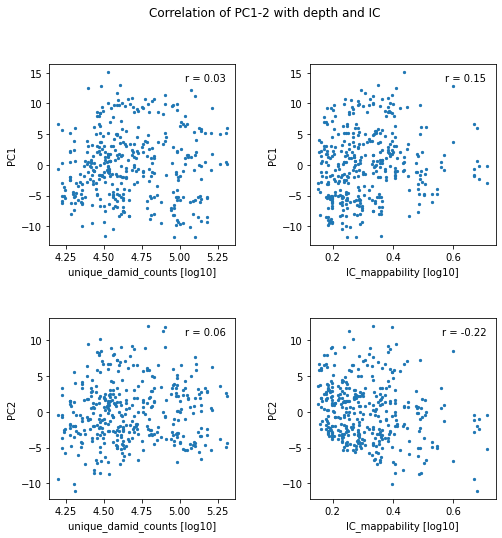

In [67]:
pca_results['stage_treatment_parent'] = pca_results.apply(axis=1, func = lambda r: '%s_%s_%s' % (r['stage'], r['treatment'], r['parent']))
plot_pca_results(pca_results, explained_var, additional_cols={'Per stage & treatment & allele': 'stage_treatment_parent'})

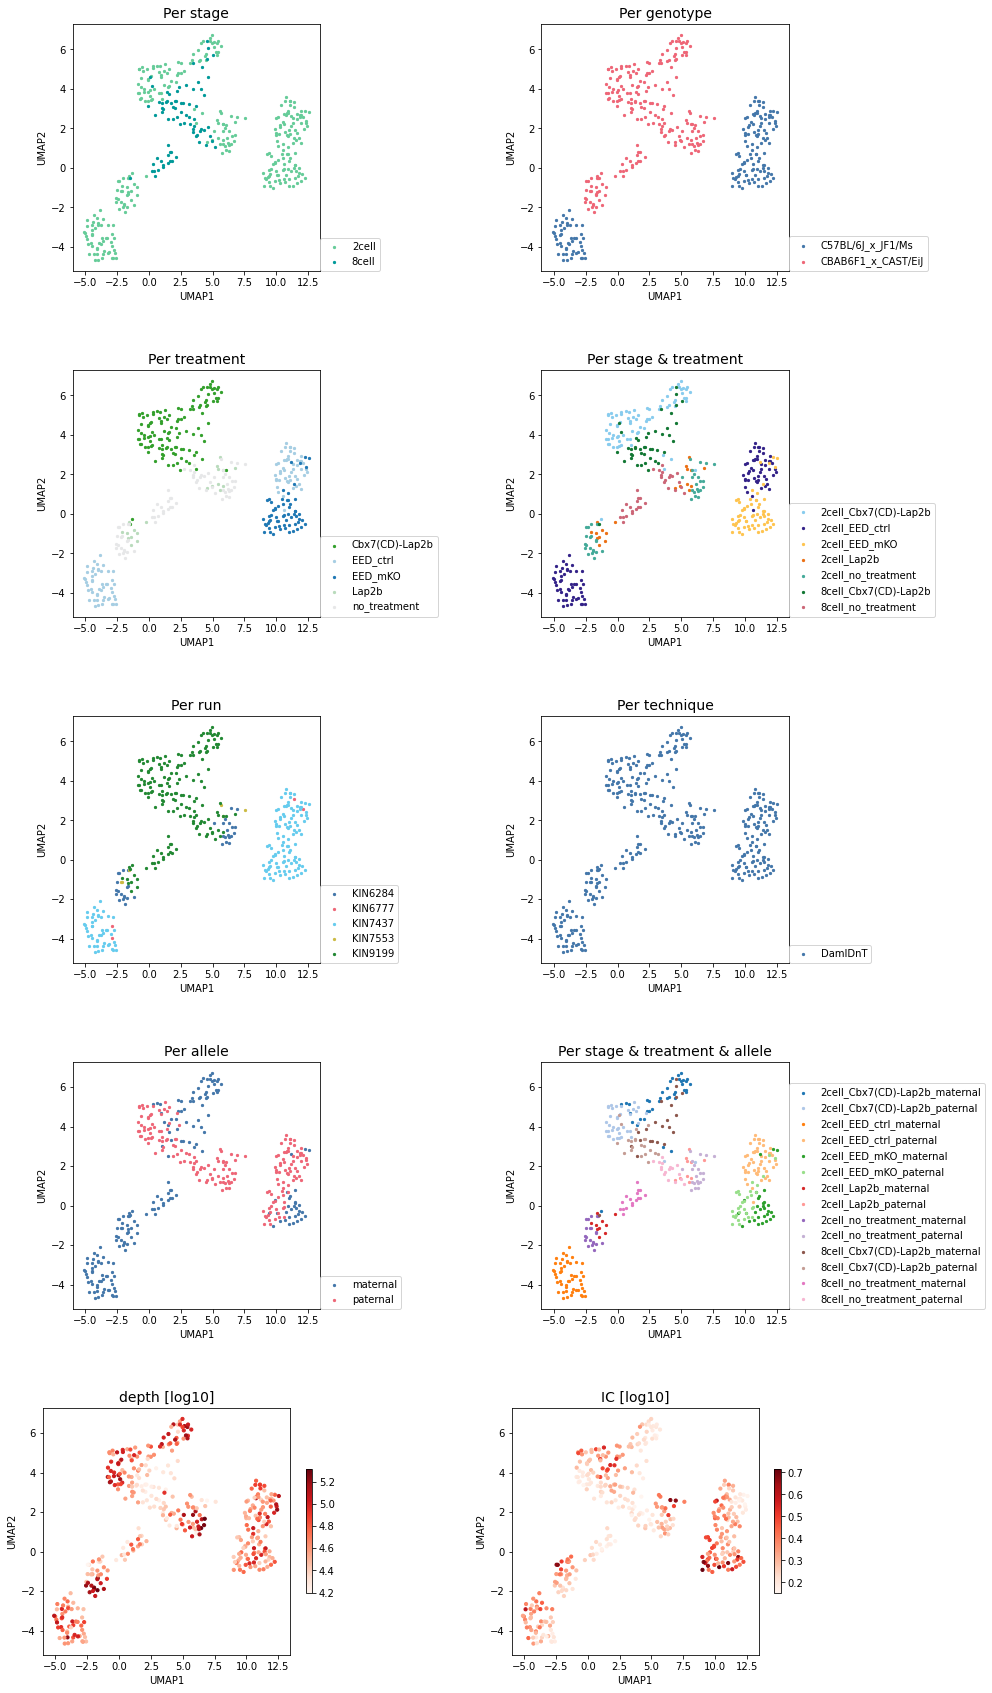

In [68]:
umap_results['stage_treatment_parent'] = umap_results.apply(axis=1, func = lambda r: '%s_%s_%s' % (r['stage'], r['treatment'], r['parent']))

plot_umap_results(umap_results, additional_cols={'Per allele': 'parent', 'Per stage & treatment & allele': 'stage_treatment_parent'})

outfn = FIGOUTDIR + 'scUMAP_joined_alleles.2cell_8cell_hybrid_embryo.lognorm_data.binsize_%d.pdf' % BINSIZE
if binary_data:
    outfn = outfn.replace('lognorm', 'binary')

plt.savefig(outfn, bbox_inches='tight')

# Joined allele UMAP - all embryo hybrid samples

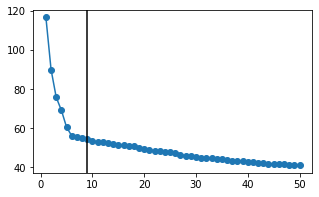

Using PCs:  [0 1 2 3 4 5 6 7 8]


In [69]:
chrom_select = np.array(chrom_order[:-2])

ind = anno.is_heterozygous & anno.DamID_PASS_allelic & (anno.cellcount==1) & (anno.stage != 'mESC')
samples = anno[ind].index.values

filt = np.concatenate([mapab[c] for c in chrom_select]) > MINMAP
for gt in anno.loc[samples,'genotype'].unique():
    gt_filt = np.concatenate([allele_filt_gt[gt][c] for c in chrom_select])
    filt = filt & gt_filt

binary_data = False

pca_results, umap_results, explained_var = compute_PCA_and_UMAP_joined_alleles(
    samples, chrom_select, filt, npc=9, binary_data=binary_data
)

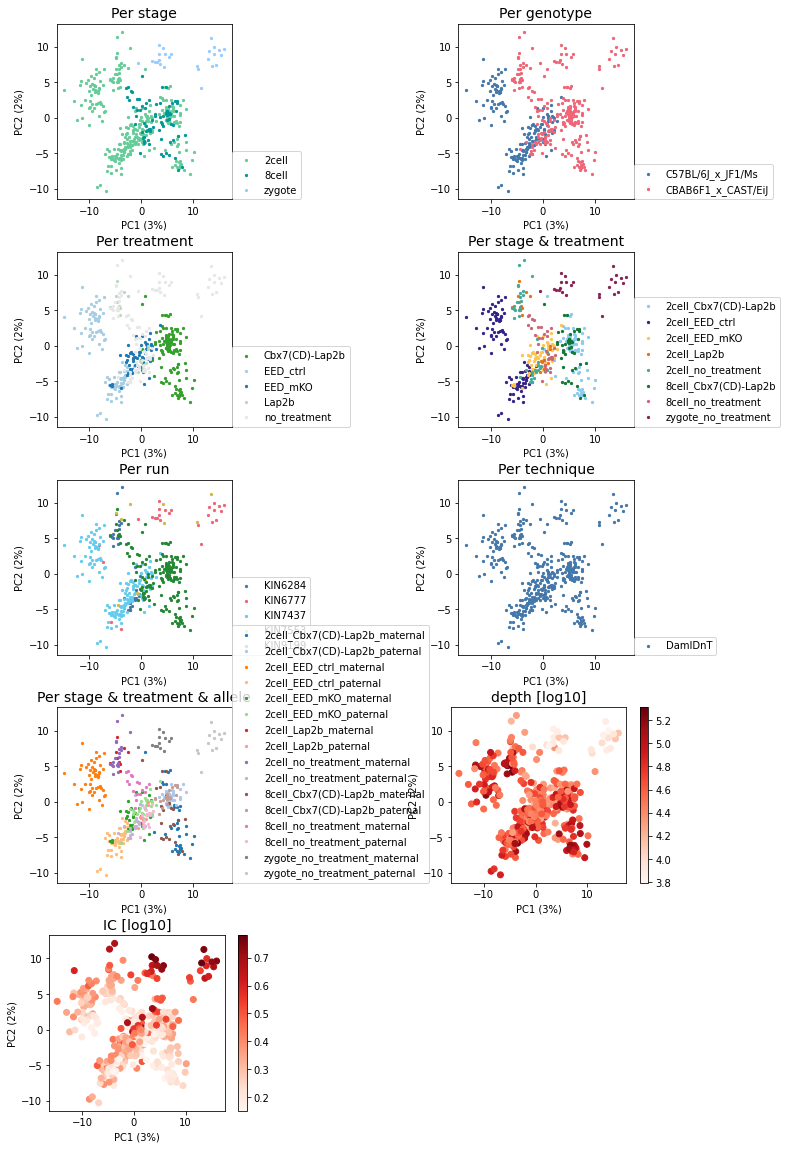

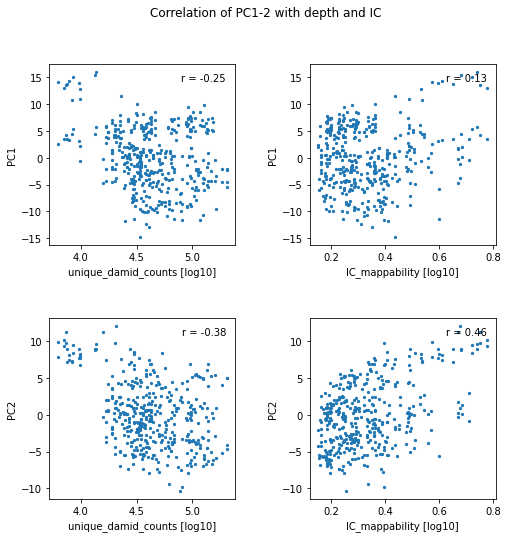

In [70]:
pca_results['stage_treatment_parent'] = pca_results.apply(axis=1, func = lambda r: '%s_%s_%s' % (r['stage'], r['treatment'], r['parent']))
plot_pca_results(pca_results, explained_var, additional_cols={'Per stage & treatment & allele': 'stage_treatment_parent'})

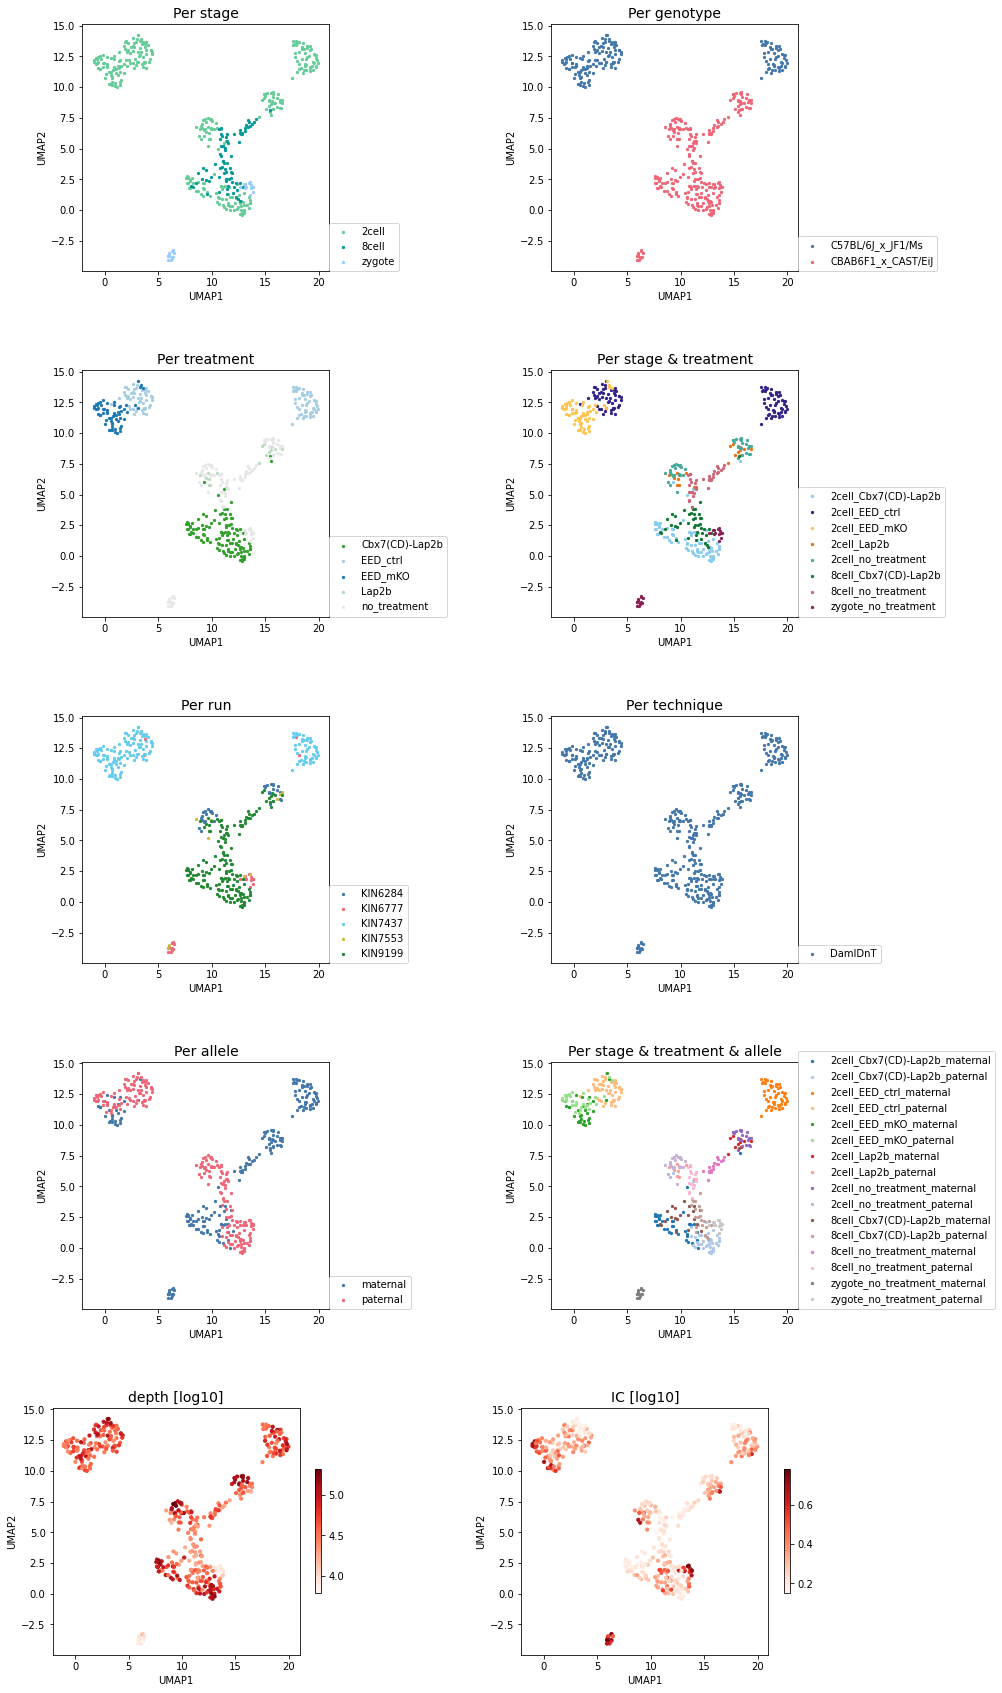

In [71]:
umap_results['stage_treatment_parent'] = umap_results.apply(axis=1, func = lambda r: '%s_%s_%s' % (r['stage'], r['treatment'], r['parent']))

plot_umap_results(umap_results, additional_cols={'Per allele': 'parent', 'Per stage & treatment & allele': 'stage_treatment_parent'})

outfn = FIGOUTDIR + 'scUMAP_joined_alleles.hybrid_embryo.lognorm_data.binsize_%d.pdf' % BINSIZE
if binary_data:
    outfn = outfn.replace('lognorm', 'binary')

plt.savefig(outfn, bbox_inches='tight')

# UMAP of hybrid samples based on maternal & paternal signal - excluding Peters data

PC2 has correlation with depth of -0.56


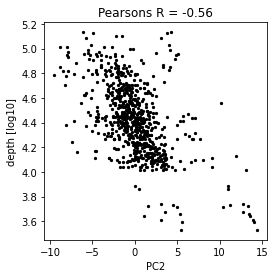

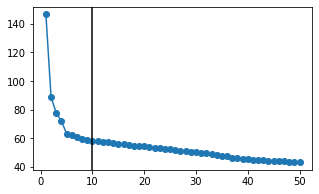

Using PCs:  [0 1 2 3 4 5 6 7 8 9]


In [72]:
chrom_select = np.array(chrom_order[:-2])
chrom_select = chrom_select[chrom_select != '12']

ind = anno.is_heterozygous & anno.DamID_PASS_allelic & (anno.cellcount==1) & (anno.genotype != 'C57BL/6J_x_JF1/Ms')
samples = anno[ind].index.values

filt = np.concatenate([mapab[c] for c in chrom_select]) > MINMAP
for gt in anno.loc[samples,'genotype'].unique():
    gt_filt = np.concatenate([allele_filt_gt[gt][c] for c in chrom_select])
    filt = filt & gt_filt

pca_results, umap_results, explained_var = compute_PCA_and_UMAP_joined_alleles(
    samples, chrom_select, filt, npc=10, binary_data=False
)

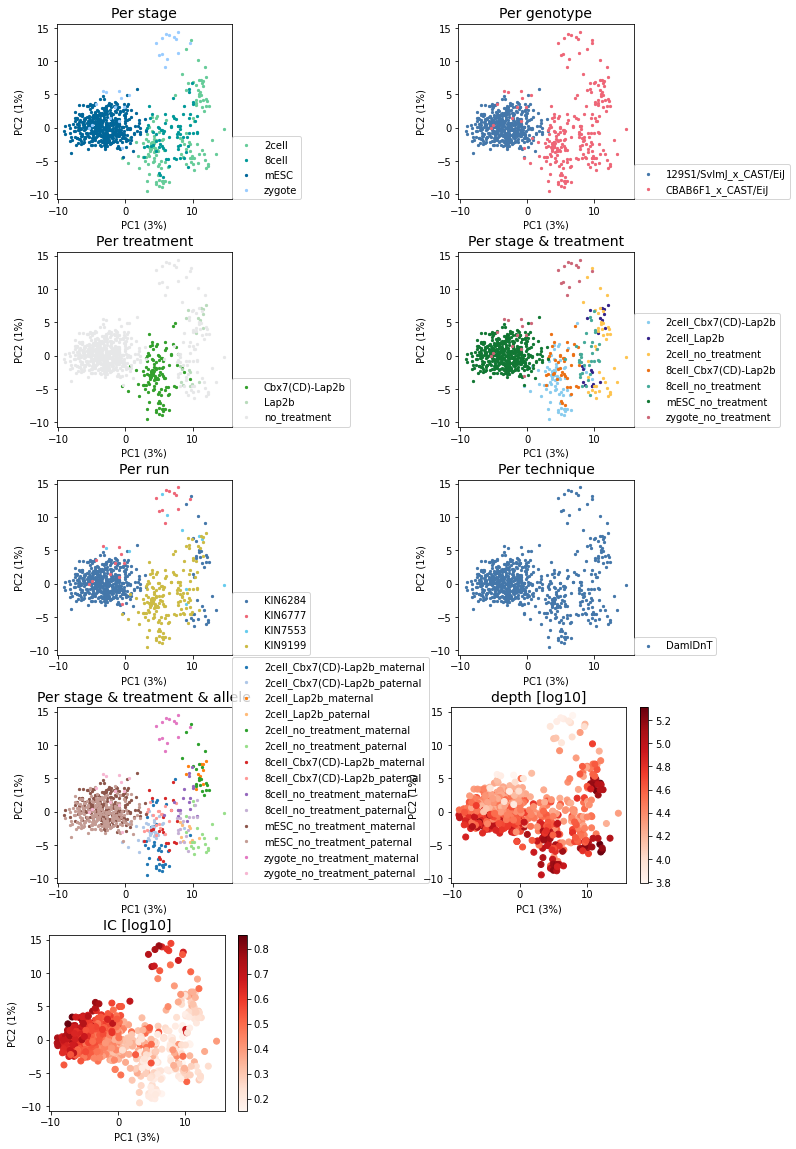

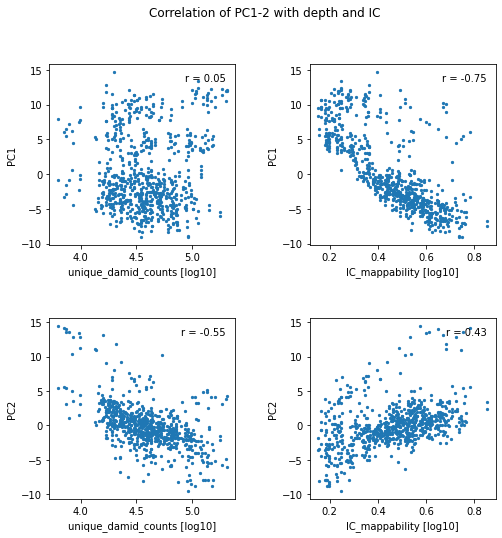

In [73]:
pca_results['stage_treatment_parent'] = pca_results.apply(axis=1, func = lambda r: '%s_%s_%s' % (r['stage'], r['treatment'], r['parent']))
plot_pca_results(pca_results, explained_var, additional_cols={'Per stage & treatment & allele': 'stage_treatment_parent'})

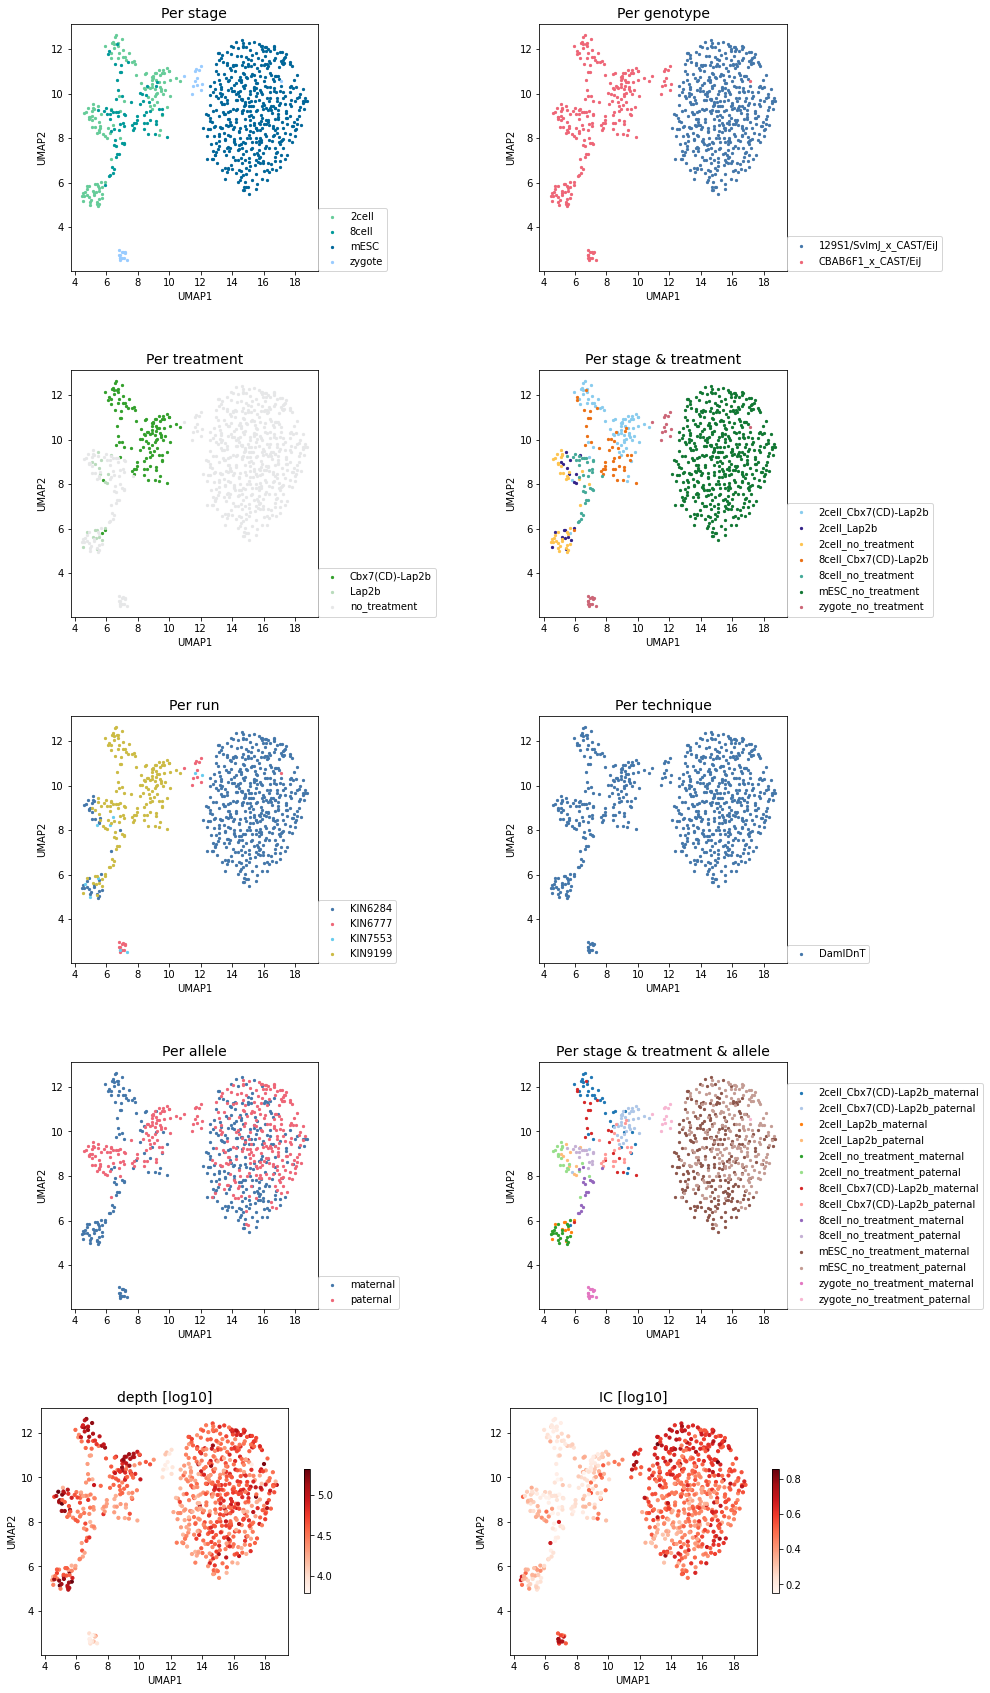

In [74]:
umap_results['stage_treatment_parent'] = umap_results.apply(axis=1, func = lambda r: '%s_%s_%s' % (r['stage'], r['treatment'], r['parent']))

plot_umap_results(umap_results, additional_cols={'Per allele': 'parent', 'Per stage & treatment & allele': 'stage_treatment_parent'})

outfn = FIGOUTDIR + 'scUMAP_joined_alleles.Kind_hybrid_embryo_and_mESC.lognorm_data.binsize_%d.pdf' % BINSIZE
if binary_data:
    outfn = outfn.replace('lognorm', 'binary')
plt.savefig(outfn, bbox_inches='tight')